# About the notebook
This script has different adjustments of the three models (logistic regression, random forest and gradient boosting). The performances of all adjustments are recorded to find a final model. In the end it is compared ti ther scores, uncorrected features and other feature combinations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import savgol_filter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc,accuracy_score,precision_recall_curve
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression,PLSCanonical

# Read in the data

In [2]:
# params
cancer_type = "breast_cancer"
GC = "corrected"
score = "MIDPOINT"
amplitude = "FFT"

In [3]:
# cancer features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+cancer_type+"_"+GC+"_"+score+"_"+amplitude+"_features.csv"
c_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_breast_cancer_metadata.tsv"
c_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

c_features = c_features.reset_index(drop=False)
c_features[['sample','p','score']] = c_features['index'].str.split('_',2, expand=True)
c_features = c_features.set_index('sample')
cancer = pd.concat([c_features, c_meta], axis=1)

In [4]:
# healthy features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_"+GC+"_"+score+"_"+amplitude+"_features.csv"
h_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_metadata.tsv"
h_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

h_features = h_features.reset_index(drop=False)
h_features[['sample','p','score']] = h_features['index'].str.split('_',2, expand=True)
h_features = h_features.set_index('sample')
healthy = pd.concat([h_features, h_meta], axis=1)

In [5]:
# concat breast cancer and healthy
data = pd.concat([cancer, healthy], axis=0) #pd.concat([data1, data2], axis=0)
features = data.columns[(data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('mean_cov')) | (data.columns.str.startswith('amplitude')) | (data.columns.str.startswith('nucleosome_spacing'))]
data.head()

,index,phenotype,central_coverage_NFKB2,mean_coverage_NFKB2,amplitude190_NFKB2,nucleosome_spacing_fft_NFKB2,central_coverage_TP73,mean_coverage_TP73,amplitude190_TP73,nucleosome_spacing_fft_TP73,...,Gender,Stage,Age,Status,% GC,Length,Median,≥ 1X,≥ 5X,fraction
EGAF00002727253,EGAF00002727253_c_MIDPOINT,1.0,0.921859,0.999899,5.964870,148.0,0.993629,0.999585,15.140059,192.0,...,F,I,54.0,breast_cancer,41%,140 bp,2.0X,88.0%,1.0%,0.06429
EGAF00002727240,EGAF00002727240_c_MIDPOINT,1.0,0.966934,1.000200,19.353707,192.0,1.033113,1.000039,9.433198,240.0,...,F,II,61.0,breast_cancer,42%,143 bp,2.0X,88.0%,3.0%,0.36440
EGAF00002727280,EGAF00002727280_c_MIDPOINT,1.0,1.161236,0.999987,11.505221,213.0,1.115174,0.999805,17.278634,192.0,...,F,II,37.0,breast_cancer,42%,134 bp,2.0X,86.0%,1.0%,0.09767
EGAF00002727290,EGAF00002727290_c_MIDPOINT,1.0,1.027811,0.999776,20.178665,192.0,1.038958,1.000246,3.898227,160.0,...,F,II,48.0,breast_cancer,41%,139 bp,2.0X,89.0%,2.0%,0.06922
EGAF00002727254,EGAF00002727254_c_MIDPOINT,1.0,1.118326,1.000246,10.611337,213.0,1.166457,0.999947,1.834101,213.0,...,F,II,47.0,breast_cancer,41%,134 bp,1.0X,86.0%,1.0%,0.11470


In [6]:
train,test = train_test_split(data, test_size = 0.25, random_state = 42)
# 81 training samples
# 27 testing samples

X_train = train[features]
y_train = train.loc[:,"phenotype"]
X_test = test[features]
y_test = test.loc[:,"phenotype"]

In [7]:
#scale data
scaled_data = pd.concat([cancer, healthy], axis=0) 
scaler = StandardScaler()
scaler.fit(scaled_data[features])
scaled_data[features] = scaler.transform(scaled_data[features])
scaled_data[features].mean()

scaled_data.head()

,index,phenotype,central_coverage_NFKB2,mean_coverage_NFKB2,amplitude190_NFKB2,nucleosome_spacing_fft_NFKB2,central_coverage_TP73,mean_coverage_TP73,amplitude190_TP73,nucleosome_spacing_fft_TP73,...,Gender,Stage,Age,Status,% GC,Length,Median,≥ 1X,≥ 5X,fraction
EGAF00002727253,EGAF00002727253_c_MIDPOINT,1.0,-1.587964,-0.402804,-1.431977,-2.181180,-1.235524,-2.211313,0.879156,-0.406840,...,F,I,54.0,breast_cancer,41%,140 bp,2.0X,88.0%,1.0%,0.06429
EGAF00002727240,EGAF00002727240_c_MIDPOINT,1.0,-0.575681,1.081786,0.380465,-0.469377,-0.233665,0.148223,-0.184884,1.386579,...,F,II,61.0,breast_cancer,42%,143 bp,2.0X,88.0%,3.0%,0.36440
EGAF00002727280,EGAF00002727280_c_MIDPOINT,1.0,3.787805,0.031149,-0.681981,0.347620,1.848499,-1.066968,1.277891,-0.406840,...,F,II,37.0,breast_cancer,42%,134 bp,2.0X,86.0%,1.0%,0.09767
EGAF00002727290,EGAF00002727290_c_MIDPOINT,1.0,0.791448,-1.014266,0.492140,-0.469377,-0.085350,1.227604,-1.216876,-1.602453,...,F,II,48.0,breast_cancer,41%,139 bp,2.0X,89.0%,2.0%,0.06922
EGAF00002727254,EGAF00002727254_c_MIDPOINT,1.0,2.824170,1.308605,-0.802986,0.347620,3.149750,-0.327229,-1.601730,0.377780,...,F,II,47.0,breast_cancer,41%,134 bp,1.0X,86.0%,1.0%,0.11470


In [8]:
train_scaled,test_scaled = train_test_split(scaled_data, test_size = 0.25, random_state = 42)

X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled.loc[:,"phenotype"]
X_test_scaled = test_scaled[features]
y_test_scaled = test_scaled.loc[:,"phenotype"]

# Functions

In [9]:
def plot_roc_curve(tpr,fpr,AUC):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' % AUC)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'b--')
    #plt.xlim([0, 1])
    #plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Logistic regression
## default

In [236]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

pred_train = log_reg.predict(X_train)
prob_train = log_reg.predict_proba(X_train)
pred = log_reg.predict(X_test)
prob = log_reg.predict_proba(X_test)
log_reg_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train, pred_train)
fpr,tpr,_ = roc_curve(y_train, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test, pred)
fpr,tpr,_ = roc_curve(y_test, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.6296296296296297 AUC:  0.6373626373626373


/fast/users/lburkar_m/work/miniconda/envs/jupyter/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


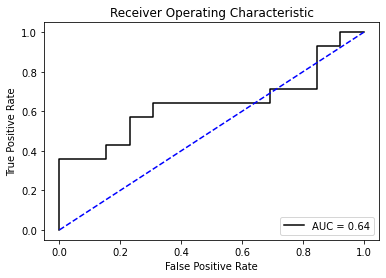

In [237]:
plot_roc_curve(tpr,fpr,AUC)

Performance is not very well.

## add scaling

In [238]:
log_reg_scaled = LogisticRegression(random_state=42)
log_reg_scaled.fit(X_train_scaled, y_train_scaled)

pred_train = log_reg_scaled.predict(X_train_scaled)
prob_train = log_reg_scaled.predict_proba(X_train_scaled)
pred = log_reg_scaled.predict(X_test_scaled)
prob = log_reg_scaled.predict_proba(X_test_scaled)
log_reg_scaled_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7407407407407407 AUC:  0.7472527472527473


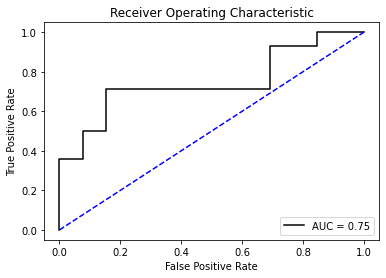

In [239]:
plot_roc_curve(tpr,fpr,AUC)

Scaling improves model performance and is therefore kept.
This means that the feature values are highly different. We expect that to make an influence on a logistic regression model.

## add hyperparameter optimization

In [66]:
hyperparameters = {'C': [0.0001, 0.001,0.01,0.1,1,10,100,1000],
                  'max_iter': range(100,501,25),
                  'solver': ['liblinear','saga'],
                  'penalty': ['l1', 'l2']}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 

model = LogisticRegression()
search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=cv, n_jobs=-1, verbose=3, return_train_score=True)
search.fit(X_train_scaled, y_train_scaled)
best_C = search.best_params_['C']
best_max_iter = search.best_params_['max_iter']
best_solver = search.best_params_['solver']
best_penalty = search.best_params_['penalty']
print("best score: ", search.best_score_)
print(search.best_params_)

log_reg_hpo = LogisticRegression(max_iter=best_max_iter, C=best_C, solver=best_solver, 
                           penalty=best_penalty, random_state=42)
log_reg_hpo.fit(X_train_scaled, y_train_scaled)

#predict the test data
pred_train = log_reg_hpo.predict(X_train_scaled)
prob_train = log_reg_hpo.predict_proba(X_train_scaled)
pred = log_reg_hpo.predict(X_test_scaled)
prob = log_reg_hpo.predict_proba(X_test_scaled)
log_reg_hpo_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

Fitting 10 folds for each of 544 candidates, totalling 5440 fits
best score:  0.8541666666666666
{'C': 10, 'max_iter': 250, 'penalty': 'l1', 'solver': 'liblinear'}
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.5925925925925926 AUC:  0.7032967032967032


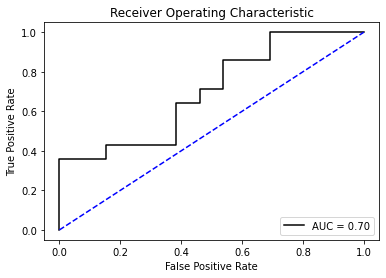

In [242]:
plot_roc_curve(tpr,fpr,AUC)

When adding hyperparameter optimization the model performace gets slightly worse. However it is better to select the hyperparameters with optimization than just using default values.

## add PCA

In [243]:
# with hyperparameter optimization
fraction_variance = .8

#perform PCA on the training set
n_components = min(len(features), len(X_train_scaled))
pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
PCs = pca.fit_transform(X_train_scaled[features])
principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train_scaled.index)

#find the principle components that make up 80% of the varience
for j in range(len(pca.explained_variance_ratio_)):
    current_sum = pca.explained_variance_ratio_[:j].sum()
    if current_sum>=fraction_variance:
        break
print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

#apply to the test data
test_PCs = pca.transform(X_test_scaled[features])
test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test_scaled.index)

X_train_pca = principal_components[pca_features]
X_test_pca = test_principal_components[pca_features]


hyperparameters = {'C': [0.0001, 0.001,0.01,0.1,1,10,100,1000],
                  'class_weight':[None, 'balanced'],
                  'max_iter': range(100,501,25),
                  'solver': ['liblinear'],
                  'penalty': ['l1', 'l2']}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 

model = LogisticRegression()
search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=cv, n_jobs=-1, verbose=3, return_train_score=True)
search.fit(X_train_pca, y_train_scaled)
best_C = search.best_params_['C']
best_class_weight = search.best_params_['class_weight']
best_max_iter = search.best_params_['max_iter']
best_solver = search.best_params_['solver']
best_penalty = search.best_params_['penalty']
print("best score: ", search.best_score_)
print(search.best_params_)

##train a new model on the full training dataset (is this the same as refit...?)
log_reg_pca_hpo = LogisticRegression(class_weight=best_class_weight, max_iter=best_max_iter, C=best_C, solver=best_solver, 
                           penalty=best_penalty, random_state=42)
log_reg_pca_hpo.fit(X_train_pca, y_train_scaled)

#predict the test data
pred_train = log_reg_pca_hpo.predict(X_train_pca)
prob_train = log_reg_pca_hpo.predict_proba(X_train_pca)
pred = log_reg_pca_hpo.predict(X_test_pca)
prob = log_reg_pca_hpo.predict_proba(X_test_pca)
log_reg_pca_hpo_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
#log_reg_hpo_prob = prob[:,1]
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

total components 81 number of components: 49
Fitting 10 folds for each of 544 candidates, totalling 5440 fits
best score:  0.7388888888888889
{'C': 0.0001, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
TRAINING - Accuracy:  0.8518518518518519 AUC:  0.9164634146341464
TESTING - Accuracy:  0.5925925925925926 AUC:  0.554945054945055


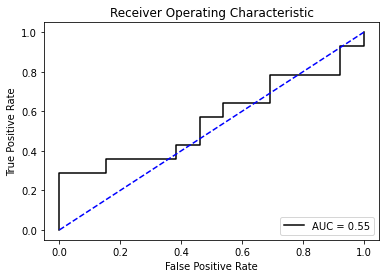

In [244]:
plot_roc_curve(tpr,fpr,AUC)

In [245]:
# without hyperparameter optimization
fraction_variance = .8

#perform PCA on the training set
n_components = min(len(features), len(X_train_scaled))
pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
PCs = pca.fit_transform(X_train_scaled[features])
principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train_scaled.index)

#find the principle components that make up 80% of the varience
for j in range(len(pca.explained_variance_ratio_)):
    current_sum = pca.explained_variance_ratio_[:j].sum()
    if current_sum>=fraction_variance:
        break
print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

#apply to the test data
test_PCs = pca.transform(X_test_scaled[features])
test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test_scaled.index)

X_train_pca = principal_components[pca_features]
X_test_pca = test_principal_components[pca_features]

log_reg_pca = LogisticRegression(random_state=42)
log_reg_pca.fit(X_train_pca, y_train_scaled)

#predict the test data
pred_train = log_reg_pca.predict(X_train_pca)
prob_train = log_reg_pca.predict_proba(X_train_pca)
pred = log_reg_pca.predict(X_test_pca)
prob = log_reg_pca.predict_proba(X_test_pca)
log_reg_pca_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

total components 81 number of components: 49
TRAINING - Accuracy:  0.9876543209876543 AUC:  1.0
TESTING - Accuracy:  0.6296296296296297 AUC:  0.6538461538461539


In [332]:
# without hyperparameter optimization and without scaling
fraction_variance = .8

#perform PCA on the training set
n_components = min(len(features), len(X_train))
pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
PCs = pca.fit_transform(X_train[features])
principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

#find the principle components that make up 80% of the varience
for j in range(len(pca.explained_variance_ratio_)):
    current_sum = pca.explained_variance_ratio_[:j].sum()
    if current_sum>=fraction_variance:
        break
print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

#apply to the test data
test_PCs = pca.transform(X_test[features])
test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

X_train_pca = principal_components[pca_features]
X_test_pca = test_principal_components[pca_features]

log_reg_pca = LogisticRegression(random_state=42)
log_reg_pca.fit(X_train_pca, y_train)

#predict the test data
pred_train = log_reg_pca.predict(X_train_pca)
prob_train = log_reg_pca.predict_proba(X_train_pca)
pred = log_reg_pca.predict(X_test_pca)
prob = log_reg_pca.predict_proba(X_test_pca)
log_reg_pca_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train, pred_train)
fpr,tpr,_ = roc_curve(y_train, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test, pred)
fpr,tpr,_ = roc_curve(y_test, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

total components 81 number of components: 47
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.5185185185185185 AUC:  0.6043956043956044


/fast/users/lburkar_m/work/miniconda/envs/jupyter/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


When adding PCA the model performance gets worse. That means that some of the smaller components are not just random noise but important for the model

## manual hyperparameters

In [482]:
log_reg_manual = LogisticRegression(C=0.1, class_weight=None, max_iter=500, penalty='l1', solver='liblinear', 
                                    random_state = 42)
log_reg_manual.fit(X_train, y_train)

pred_train = log_reg_manual.predict(X_train)
prob_train = log_reg_manual.predict_proba(X_train)
pred = log_reg_manual.predict(X_test)
prob = log_reg_manual.predict_proba(X_test)
log_reg_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train, pred_train)
fpr,tpr,_ = roc_curve(y_train, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test, pred)
fpr,tpr,_ = roc_curve(y_test, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.48148148148148145 AUC:  0.41208791208791207


In [483]:
# with scaled data
log_reg_manual = LogisticRegression(C=0.1, class_weight=None, max_iter=500, penalty='l1', solver='liblinear', 
                                    random_state = 42)
log_reg_manual.fit(X_train_scaled, y_train_scaled)

pred_train = log_reg_manual.predict(X_train_scaled)
prob_train = log_reg_manual.predict_proba(X_train_scaled)
pred = log_reg_manual.predict(X_test_scaled)
prob = log_reg_manual.predict_proba(X_test_scaled)
log_reg_manual_scaled_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  0.9259259259259259 AUC:  0.9859756097560975
TESTING - Accuracy:  0.6666666666666666 AUC:  0.8076923076923077


In [443]:
# with PCA
fraction_variance = .8

#perform PCA on the training set
n_components = min(len(features), len(X_train))
pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
PCs = pca.fit_transform(X_train[features])
principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

#find the principle components that make up 80% of the varience
for j in range(len(pca.explained_variance_ratio_)):
    current_sum = pca.explained_variance_ratio_[:j].sum()
    if current_sum>=fraction_variance:
        break
print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

#apply to the test data
test_PCs = pca.transform(X_test[features])
test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

X_train_pca = principal_components[pca_features]
X_test_pca = test_principal_components[pca_features]

log_reg_manual = LogisticRegression(C=0.1, class_weight=None, max_iter=500, penalty='l1', solver='liblinear', 
                                    random_state = 42)
log_reg_manual.fit(X_train_pca, y_train)

pred_train = log_reg_manual.predict(X_train_pca)
prob_train = log_reg_manual.predict_proba(X_train_pca)
pred = log_reg_manual.predict(X_test_pca)
prob = log_reg_manual.predict_proba(X_test_pca)
#rf_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train, pred_train)
fpr,tpr,_ = roc_curve(y_train, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test, pred)
fpr,tpr,_ = roc_curve(y_test, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

total components 81 number of components: 47
TRAINING - Accuracy:  0.9629629629629629 AUC:  0.9981707317073171
TESTING - Accuracy:  0.5925925925925926 AUC:  0.5989010989010989


In [69]:
# with scaled data and with PCA
fraction_variance = .8

#perform PCA on the training set
n_components = min(len(features), len(X_train_scaled))
pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
PCs = pca.fit_transform(X_train_scaled[features])
principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train_scaled.index)

#find the principle components that make up 80% of the varience
for j in range(len(pca.explained_variance_ratio_)):
    current_sum = pca.explained_variance_ratio_[:j].sum()
    if current_sum>=fraction_variance:
        break
print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

#apply to the test data
test_PCs = pca.transform(X_test_scaled[features])
test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test_scaled.index)

X_train_pca = principal_components[pca_features]
X_test_pca = test_principal_components[pca_features]

log_reg_manual = LogisticRegression(C=0.1, class_weight=None, max_iter=500, penalty='l1', solver='liblinear', 
                                    random_state = 42)
log_reg_manual.fit(X_train_pca, y_train)

pred_train = log_reg_manual.predict(X_train_pca)
prob_train = log_reg_manual.predict_proba(X_train_pca)
pred = log_reg_manual.predict(X_test_pca)
prob = log_reg_manual.predict_proba(X_test_pca)
#rf_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train, pred_train)
fpr,tpr,_ = roc_curve(y_train, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test, pred)
fpr,tpr,_ = roc_curve(y_test, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

total components 81 number of components: 49
TRAINING - Accuracy:  0.9506172839506173 AUC:  0.9871951219512196
TESTING - Accuracy:  0.6666666666666666 AUC:  0.6593406593406593


# Random Forest
## default

In [80]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)

pred_train = rf.predict(X_train)
prob_train = rf.predict_proba(X_train)
pred = rf.predict(X_test)
prob = rf.predict_proba(X_test)
rf_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train, pred_train)
fpr,tpr,_ = roc_curve(y_train, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test, pred)
fpr,tpr,_ = roc_curve(y_test, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7407407407407407 AUC:  0.8324175824175825


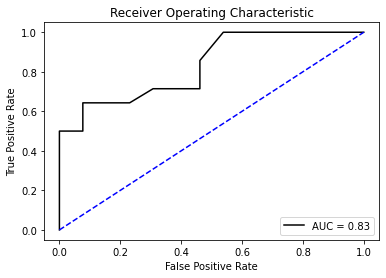

In [81]:
plot_roc_curve(tpr,fpr,AUC)

In [83]:
# feature importance
pd.DataFrame(data=rf.feature_importances_, columns=["importance"], index=features).sort_values(by="importance", ascending=False)

,importance
central_coverage_PAX5,0.019076
central_coverage_CEBPB,0.012564
central_coverage_FLI1,0.012466
central_coverage_RUNX1,0.012006
central_coverage_ZNF121,0.011962
...,...
amplitude190_ESR2,0.000000
central_coverage_ESR2,0.000000
nucleosome_spacing_fft_FOXH1,0.000000
amplitude190_FOXH1,0.000000


In [ ]:
feature_importance = pd.DataFrame(data=rf.feature_importances_, columns=["importance"], index=features).sort_values(by="importance", ascending=False)
correlation_matrix = pd.DataFrame(index = feature_importance.index, columns = feature_importance.index, dtype=float)

for row in correlation_matrix.index:
    for col in correlation_matrix.columns:
        correlation_matrix.loc[row,col] = data[[row,col]].corr().iloc[0,1]

correlation_matrix

In [329]:
n_features = 20
feature_importance = pd.DataFrame(data=rf.feature_importances_, columns=["importance"], index=features).sort_values(by="importance", ascending=False)
feature_importance = feature_importance.head(n_features).index
reduced_set = data.loc[:,feature_importance]
reduced_set["phenotype"] = data["phenotype"]

,central_coverage_PAX5,central_coverage_CEBPB,central_coverage_FLI1,central_coverage_RUNX1,central_coverage_ZNF121,central_coverage_MYC,central_coverage_SMAD5,central_coverage_HOXC5,central_coverage_BATF,central_coverage_MAFG,...,central_coverage_ZNF143,central_coverage_FOXK2,central_coverage_STAT1,central_coverage_CREB1,amplitude190_STAT3,central_coverage_VEZF1,amplitude190_RBPJ,amplitude190_ZKSCAN1,central_coverage_ZNF384,phenotype
EGAF00002727253,-0.402941,-0.614294,0.396937,0.014986,-0.494323,-1.200050,-1.066364,0.283368,-1.365302,-0.343668,...,-1.259762,0.419321,-1.194617,-0.921778,-1.694955,-1.550855,0.382533,1.532071,0.254169,1.0
EGAF00002727240,1.333927,0.528234,2.796407,0.880067,2.113310,2.218848,1.943462,-0.710099,0.526032,-1.382569,...,-0.306465,-0.852933,0.955136,-0.514627,1.855013,0.427121,-0.320071,-1.137443,1.541838,1.0
EGAF00002727280,4.440459,2.826859,3.823940,6.017916,-0.977799,2.856378,1.746330,3.948251,2.448287,1.432316,...,4.027880,3.520677,5.186407,5.163371,-0.032015,2.658811,-1.162344,-1.612879,-0.446188,1.0
EGAF00002727290,0.457414,0.643187,0.513925,0.396351,-1.514932,0.059169,-0.198671,-0.533116,1.137067,0.462127,...,0.530051,0.791014,0.696554,1.075123,-1.511297,1.647634,1.192606,0.267201,-0.342034,1.0
EGAF00002727254,3.856750,2.178514,2.539172,3.784565,-1.181871,3.056911,2.317404,3.242843,0.483662,-0.783052,...,3.508962,2.949293,3.748920,3.912200,1.045850,3.694621,-0.907592,2.355105,-0.764212,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EGAF00002727649,-0.997162,-1.664935,-1.339437,-0.507436,-0.864127,-0.832427,-1.524943,-0.556612,-0.353676,-0.083142,...,-0.546238,-0.997782,-1.232283,-0.867555,0.629689,-0.539457,-0.458078,-1.447095,-0.181948,0.0
EGAF00002727610,-1.066006,-2.355841,0.096846,-0.509623,-0.380449,-0.789954,-0.430991,-0.422035,-1.570518,0.024520,...,-0.653155,-0.659511,-0.274667,-0.186375,1.408110,-1.164056,0.129086,-0.333701,-0.447087,0.0
EGAF00002727607,-1.064931,-0.585475,-1.507445,-1.635493,0.242935,-1.826096,-0.934377,-0.929102,-0.714009,-1.270760,...,-1.091156,-1.167843,-1.502623,-1.185168,-0.874370,0.300671,-0.639889,-0.090222,0.307963,0.0
EGAF00002727528,0.054522,1.443270,-0.252135,-0.430253,-1.637559,-0.614543,0.000085,0.308686,1.360869,-1.228623,...,-0.612193,0.497715,-0.382512,-0.016150,0.083675,1.225632,-0.895691,0.006393,-1.071286,0.0


In [330]:
# make a new model on the reduced features
train_reduced,test_reduced = train_test_split(reduced_set, test_size = 0.25, random_state = 42)

X_train_reduced = train_reduced.drop(["phenotype"], axis = 1)
y_train_reduced = train_reduced.loc[:,"phenotype"]
X_test_reduced = test_reduced.drop(["phenotype"], axis = 1)
y_test_reduced = test_reduced.loc[:,"phenotype"]

In [331]:

rf_reduced = RandomForestClassifier(random_state = 42)
rf_reduced.fit(X_train_reduced, y_train_reduced)

pred_train = rf_reduced.predict(X_train_reduced)
prob_train = rf_reduced.predict_proba(X_train_reduced)
pred = rf_reduced.predict(X_test_reduced)
prob = rf_reduced.predict_proba(X_test_reduced)
rf_reduced_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_reduced, pred_train)
fpr,tpr,_ = roc_curve(y_train_reduced, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_reduced, pred)
fpr,tpr,_ = roc_curve(y_test_reduced, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  0.9999999999999999
TESTING - Accuracy:  0.6296296296296297 AUC:  0.7857142857142857


RF has a better default performance than logistic regression. Using a reduced feature set with only features of high importance does not improve model performance.

## add scaling

In [248]:
rf_scaled = RandomForestClassifier(random_state = 42)
rf_scaled.fit(X_train_scaled, y_train_scaled)

pred_train = rf_scaled.predict(X_train_scaled)
prob_train = rf_scaled.predict_proba(X_train_scaled)
pred = rf_scaled.predict(X_test_scaled)
prob = rf_scaled.predict_proba(X_test_scaled)
rf_scaled_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7407407407407407 AUC:  0.8379120879120879


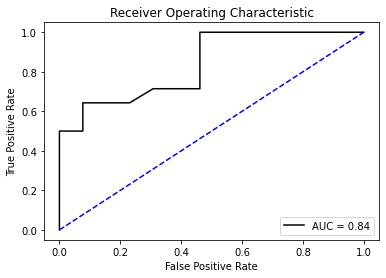

In [249]:
plot_roc_curve(tpr,fpr,AUC)

In [265]:
# feature importance
pd.DataFrame(data=rf_scaled.feature_importances_, columns=["importance"], index=features).sort_values(by="importance", ascending=False)

,importance
central_coverage_PAX5,0.019076
central_coverage_CEBPB,0.012564
central_coverage_FLI1,0.012466
central_coverage_RUNX1,0.012006
central_coverage_ZNF121,0.011962
...,...
nucleosome_spacing_fft_ESR2,0.000000
central_coverage_ESR2,0.000000
nucleosome_spacing_fft_FOXH1,0.000000
amplitude190_FOXH1,0.000000


Scaling does not change the performance. It is also not expected to influence the performance of a random forest. Is kept anyways because its also used in logistic regression.

## add hyperparameter optimization

In [79]:
n_estimators = range(100,501,50) #list [start:stop:step], np arange
max_features = ['sqrt','log2',None] #np.arange(50,251,50)
min_samples_leaf = range(2,6)
max_depth = range(3,16)
min_samples_split = range(2,5)
criterion = ['gini','entropy']

hyperparameters = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': [True,False],
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'criterion': criterion}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 
        
model = RandomForestClassifier()
search = RandomizedSearchCV(estimator = model, param_distributions = hyperparameters, n_iter = 1000,  cv = cv, verbose=3, n_jobs = -1, return_train_score=True)        
search.fit(X_train_scaled, y_train_scaled)

print("best score: ", search.best_score_)
print(search.best_params_)
best_n_estimators = search.best_params_['n_estimators']
best_max_features = search.best_params_['max_features']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_max_depth = search.best_params_['max_depth']
best_min_samples_split = search.best_params_['min_samples_split']
best_criterion = search.best_params_['criterion']
best_bootstrap = search.best_params_['bootstrap']

rf_hpo = RandomForestClassifier(n_estimators=best_n_estimators, max_features=best_max_features, 
                               min_samples_leaf=best_min_samples_leaf, 
                               max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
                               bootstrap=best_bootstrap, criterion=best_criterion, random_state=42)
rf_hpo.fit(X_train_scaled, y_train_scaled)

#predict the test data
pred_train = rf_hpo.predict(X_train_scaled)
prob_train = rf_hpo.predict_proba(X_train_scaled)
pred = rf_hpo.predict(X_test_scaled)
prob = rf_hpo.predict_proba(X_test_scaled)
rf_hpo_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
best score:  0.8527777777777779
{'n_estimators': 500, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 11, 'criterion': 'entropy', 'bootstrap': False}
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7037037037037037 AUC:  0.8351648351648351


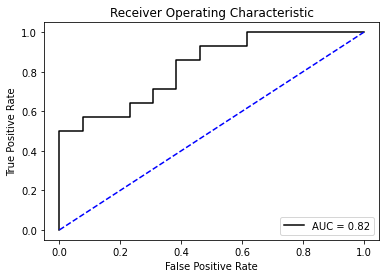

In [251]:
plot_roc_curve(tpr,fpr,AUC)

In [266]:
# feature importance
pd.DataFrame(data=rf_hpo.feature_importances_, columns=["importance"], index=features).sort_values(by="importance", ascending=False)

,importance
central_coverage_PAX5,0.025944
central_coverage_RUNX1,0.020727
central_coverage_FLI1,0.017457
central_coverage_CEBPB,0.016704
central_coverage_BCL11A,0.016172
...,...
central_coverage_FOXH1,0.000000
nucleosome_spacing_fft_ZNF316,0.000000
amplitude190_ZNF316,0.000000
mean_coverage_ZNF316,0.000000


Adding hyperparameter optimization does slightly improve the model performance. It is important to determine the values of hyperparameters through optimization.

## add PCA

In [255]:
# with hyperparameter optimization
fraction_variance = .8

#perform PCA on the training set
n_components = min(len(features), len(X_train))
pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
PCs = pca.fit_transform(X_train_scaled[features])
principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train_scaled.index)

#find the principle components that make up 80% of the varience
for j in range(len(pca.explained_variance_ratio_)):
    current_sum = pca.explained_variance_ratio_[:j].sum()
    if current_sum>=fraction_variance:
        break
print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

#apply to the test data
test_PCs = pca.transform(X_test_scaled[features])
test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test_scaled.index)

X_train_pca = principal_components[pca_features]
X_test_pca = test_principal_components[pca_features]

n_estimators = range(100,501,50) #list [start:stop:step], np arange
max_features = ['sqrt','log2',None] #np.arange(50,251,50)
min_samples_leaf = range(2,6)
max_depth = range(3,16)
min_samples_split = range(2,5)
criterion = ['gini','entropy']

hyperparameters = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': [True,False],
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'criterion': criterion}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 
        
model = RandomForestClassifier()
search = RandomizedSearchCV(estimator = model, param_distributions = hyperparameters, n_iter = 1000,  cv = cv, verbose=3, n_jobs = -1, return_train_score=True)        
search.fit(X_train_scaled, y_train_scaled)

print("best score: ", search.best_score_)
print(search.best_params_)
best_n_estimators = search.best_params_['n_estimators']
best_max_features = search.best_params_['max_features']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_max_depth = search.best_params_['max_depth']
best_min_samples_split = search.best_params_['min_samples_split']
best_criterion = search.best_params_['criterion']
best_bootstrap = search.best_params_['bootstrap']

rf_pca_hpo = RandomForestClassifier(n_estimators=best_n_estimators, max_features=best_max_features, 
                               min_samples_leaf=best_min_samples_leaf,
                               max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
                               bootstrap=best_bootstrap, criterion=best_criterion, random_state=42)
rf_pca_hpo.fit(X_train_pca, y_train_scaled)

#predict the test data
pred_train = rf_pca_hpo.predict(X_train_pca)
prob_train = rf_pca_hpo.predict_proba(X_train_pca)
pred = rf_pca_hpo.predict(X_test_pca)
prob = rf_pca_hpo.predict_proba(X_test_pca)
rf_pca_hpo_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

total components 81 number of components: 49
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
best score:  0.8402777777777779
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 15, 'criterion': 'entropy', 'bootstrap': False}
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.5925925925925926 AUC:  0.6648351648351649


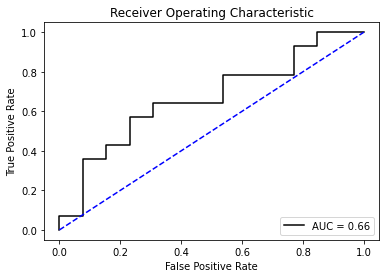

In [256]:
plot_roc_curve(tpr,fpr,AUC)

In [257]:
# without hyperparameter optimization
fraction_variance = .8

#perform PCA on the training set
n_components = min(len(features), len(X_train))
pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
PCs = pca.fit_transform(X_train_scaled[features])
principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train_scaled.index)

#find the principle components that make up 80% of the varience
for j in range(len(pca.explained_variance_ratio_)):
    current_sum = pca.explained_variance_ratio_[:j].sum()
    if current_sum>=fraction_variance:
        break
print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

#apply to the test data
test_PCs = pca.transform(X_test_scaled[features])
test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test_scaled.index)

X_train_pca = principal_components[pca_features]
X_test_pca = test_principal_components[pca_features]

rf_pca = RandomForestClassifier(random_state=42)
rf_pca.fit(X_train_pca, y_train_scaled)

#predict the test data
pred_train = rf_pca.predict(X_train_pca)
prob_train = rf_pca.predict_proba(X_train_pca)
pred = rf_pca.predict(X_test_pca)
prob = rf_pca.predict_proba(X_test_pca)
rf_pca_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

total components 81 number of components: 49
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.5185185185185185 AUC:  0.6318681318681318


In [333]:
# without hyperparameter optimization and without scaling
fraction_variance = .8

#perform PCA on the training set
n_components = min(len(features), len(X_train))
pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
PCs = pca.fit_transform(X_train[features])
principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

#find the principle components that make up 80% of the varience
for j in range(len(pca.explained_variance_ratio_)):
    current_sum = pca.explained_variance_ratio_[:j].sum()
    if current_sum>=fraction_variance:
        break
print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

#apply to the test data
test_PCs = pca.transform(X_test[features])
test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

X_train_pca = principal_components[pca_features]
X_test_pca = test_principal_components[pca_features]

model = RandomForestClassifier(random_state=42)
model.fit(X_train_pca, y_train)

#predict the test data
pred_train = model.predict(X_train_pca)
prob_train = model.predict_proba(X_train_pca)
pred = model.predict(X_test_pca)
prob = model.predict_proba(X_test_pca)

# train performance
acc = accuracy_score(y_train, pred_train)
fpr,tpr,_ = roc_curve(y_train, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test, pred)
fpr,tpr,_ = roc_curve(y_test, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

total components 81 number of components: 47
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.5925925925925926 AUC:  0.7307692307692308


Adding PCA to hyperparameter optimization makes the model performance worse, meaning again that the smaller components are important for the model.

## manual hyperparameters

In [578]:
rf_manual = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=8, criterion='gini', bootstrap=True, random_state = 42)
rf_manual.fit(X_train, y_train)

pred_train = rf_manual.predict(X_train)
prob_train = rf_manual.predict_proba(X_train)
pred = rf_manual.predict(X_test)
prob = rf_manual.predict_proba(X_test)
#rf_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train, pred_train)
fpr,tpr,_ = roc_curve(y_train, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test, pred)
fpr,tpr,_ = roc_curve(y_test, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7407407407407407 AUC:  0.8076923076923077


In [579]:
# with scaled data
rf_manual_scaled = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=8, criterion='gini', bootstrap=True, random_state = 42)
rf_manual_scaled.fit(X_train_scaled, y_train_scaled)

pred_train = rf_manual_scaled.predict(X_train_scaled)
prob_train = rf_manual_scaled.predict_proba(X_train_scaled)
pred = rf_manual_scaled.predict(X_test_scaled)
prob = rf_manual_scaled.predict_proba(X_test_scaled)
rf_manual_scaled_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7407407407407407 AUC:  0.8076923076923077


In [448]:
# with PCA
fraction_variance = .8

#perform PCA on the training set
n_components = min(len(features), len(X_train))
pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
PCs = pca.fit_transform(X_train[features])
principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

#find the principle components that make up 80% of the varience
for j in range(len(pca.explained_variance_ratio_)):
    current_sum = pca.explained_variance_ratio_[:j].sum()
    if current_sum>=fraction_variance:
        break
print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

#apply to the test data
test_PCs = pca.transform(X_test[features])
test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

X_train_pca = principal_components[pca_features]
X_test_pca = test_principal_components[pca_features]

rf_manual = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=8, criterion='gini', bootstrap=True, random_state = 42)
rf_manual.fit(X_train_pca, y_train)

pred_train = rf_manual.predict(X_train_pca)
prob_train = rf_manual.predict_proba(X_train_pca)
pred = rf_manual.predict(X_test_pca)
prob = rf_manual.predict_proba(X_test_pca)
#rf_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train, pred_train)
fpr,tpr,_ = roc_curve(y_train, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test, pred)
fpr,tpr,_ = roc_curve(y_test, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

total components 81 number of components: 47
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.5555555555555556 AUC:  0.6538461538461539


In [449]:
# with scaling and with PCA
fraction_variance = .8

#perform PCA on the training set
n_components = min(len(features), len(X_train_scaled))
pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
PCs = pca.fit_transform(X_train_scaled[features])
principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train_scaled.index)

#find the principle components that make up 80% of the varience
for j in range(len(pca.explained_variance_ratio_)):
    current_sum = pca.explained_variance_ratio_[:j].sum()
    if current_sum>=fraction_variance:
        break
print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

#apply to the test data
test_PCs = pca.transform(X_test_scaled[features])
test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test_scaled.index)

X_train_pca = principal_components[pca_features]
X_test_pca = test_principal_components[pca_features]

rf_manual = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=8, criterion='gini', bootstrap=True, random_state = 42)
rf_manual.fit(X_train_pca, y_train)

pred_train = rf_manual.predict(X_train_pca)
prob_train = rf_manual.predict_proba(X_train_pca)
pred = rf_manual.predict(X_test_pca)
prob = rf_manual.predict_proba(X_test_pca)
#rf_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train, pred_train)
fpr,tpr,_ = roc_curve(y_train, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test, pred)
fpr,tpr,_ = roc_curve(y_test, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

total components 81 number of components: 49
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.5555555555555556 AUC:  0.6978021978021978


# Gradient Boosting Classifier
## default

In [258]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

pred_train = gbc.predict(X_train)
prob_train = gbc.predict_proba(X_train)
pred = gbc.predict(X_test)
prob = gbc.predict_proba(X_test)
gbc_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train, pred_train)
fpr,tpr,_ = roc_curve(y_train, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test, pred)
fpr,tpr,_ = roc_curve(y_test, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7037037037037037 AUC:  0.7472527472527473


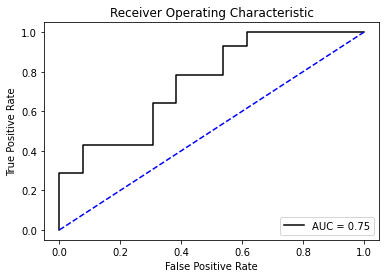

In [259]:
plot_roc_curve(tpr,fpr,AUC)

In [337]:
n_features = 20
feature_importance = pd.DataFrame(data=gbc.feature_importances_, columns=["importance"], index=features).sort_values(by="importance", ascending=False)
feature_importance = feature_importance.head(n_features).index
reduced_set = data.loc[:,feature_importance]
reduced_set["phenotype"] = data["phenotype"]
reduced_set

,central_coverage_PAX5,amplitude190_NRF1,amplitude190_TFEB,amplitude190_ESR1,central_coverage_ZNF444,amplitude190_PDX1,central_coverage_NEUROG2,nucleosome_spacing_fft_PBX1,amplitude190_MYRF,mean_coverage_MAX,...,mean_coverage_MIXL1,amplitude190_MYNN,mean_coverage_OTX2,amplitude190_NFIL3,nucleosome_spacing_fft_NR2F6,central_coverage_ZNF770,amplitude190_IRF2,mean_coverage_ZNF770,mean_coverage_YY1,phenotype
EGAF00002727253,-0.402941,-1.613988,-0.589013,-0.425170,-1.621898,0.609827,-0.869543,1.807136,-1.030441,-1.672290,...,-1.625789,1.202863,-0.168456,-0.631443,1.979408,0.056884,-2.506091,2.036381,-0.415063,1.0
EGAF00002727240,1.333927,-0.767618,-2.573975,0.539672,1.239885,1.131180,-0.732055,1.807136,-0.903173,1.459184,...,1.084367,-1.500917,-1.911653,0.585721,0.686118,-0.042774,-1.282676,-0.679259,0.138796,1.0
EGAF00002727280,4.440459,-1.033474,0.134015,-0.539056,2.549960,-0.294887,3.501794,-0.353425,-1.118310,0.487743,...,-0.873939,0.557591,-2.743187,0.035444,-0.319774,-0.304936,-1.914739,-0.513720,1.638161,1.0
EGAF00002727290,0.457414,-0.814861,-0.515123,-0.427418,0.653897,-0.018087,-0.667743,-0.353425,-0.246878,-1.150195,...,0.001478,-1.490558,0.128030,0.628491,0.686118,-1.301577,0.355600,0.080159,1.016985,1.0
EGAF00002727254,3.856750,0.313607,1.478516,-0.723665,1.817570,0.056203,3.405064,0.591820,-0.755249,-0.305553,...,0.542313,-0.039193,1.207495,0.079173,1.979408,0.949032,-2.443904,-1.356133,0.577008,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EGAF00002727649,-0.997162,-0.144659,0.058705,0.517215,-0.718400,0.049452,-0.802378,0.591820,1.379775,-1.675741,...,-0.372213,-0.155915,0.638911,0.395880,-0.319774,-1.209366,-0.347427,0.693303,-0.637634,0.0
EGAF00002727610,-1.066006,1.301079,-0.658069,1.262532,-1.312936,-1.061636,-1.026533,-0.353425,0.163164,1.361574,...,0.728256,0.657634,0.527867,-0.405429,-0.319774,-0.023364,0.004424,0.697391,1.636778,0.0
EGAF00002727607,-1.064931,0.235864,1.562528,-0.918310,-0.682355,-0.137756,-0.650603,-0.353425,1.032897,-1.240742,...,0.077706,0.693599,0.506189,1.019273,-0.319774,0.216158,0.480273,0.430312,-0.276312,0.0
EGAF00002727528,0.054522,-1.212425,0.490658,-0.058442,-0.899420,1.429034,-0.039651,-0.353425,0.492332,-1.758802,...,0.335574,-0.681998,0.609194,0.698144,-0.319774,-1.235116,1.461724,-3.028164,-0.920504,0.0


In [338]:
# make a new model on the reduced features
train_reduced,test_reduced = train_test_split(reduced_set, test_size = 0.25, random_state = 42)

X_train_reduced = train_reduced.drop(["phenotype"], axis = 1)
y_train_reduced = train_reduced.loc[:,"phenotype"]
X_test_reduced = test_reduced.drop(["phenotype"], axis = 1)
y_test_reduced = test_reduced.loc[:,"phenotype"]

In [404]:
gbc_reduced = GradientBoostingClassifier(random_state = 42)
gbc_reduced.fit(X_train_reduced, y_train_reduced)

pred_train = gbc_reduced.predict(X_train_reduced)
prob_train = gbc_reduced.predict_proba(X_train_reduced)
pred = gbc_reduced.predict(X_test_reduced)
prob = gbc_reduced.predict_proba(X_test_reduced)
gbc_reduced_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_reduced, pred_train)
fpr,tpr,_ = roc_curve(y_train_reduced, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_reduced, pred)
fpr,tpr,_ = roc_curve(y_test_reduced, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.6666666666666666 AUC:  0.7637362637362638


Gradient boosting classifier performs very similar to the Random Forest.

## add scaling

In [260]:
gbc_scaled = GradientBoostingClassifier(random_state=42)
gbc_scaled.fit(X_train_scaled, y_train_scaled)

pred_train = gbc_scaled.predict(X_train_scaled)
prob_train = gbc_scaled.predict_proba(X_train_scaled)
pred = gbc_scaled.predict(X_test_scaled)
prob = gbc_scaled.predict_proba(X_test_scaled)
gbc_scaled_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train, pred_train)
fpr,tpr,_ = roc_curve(y_train, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test, pred)
fpr,tpr,_ = roc_curve(y_test, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7037037037037037 AUC:  0.7472527472527473


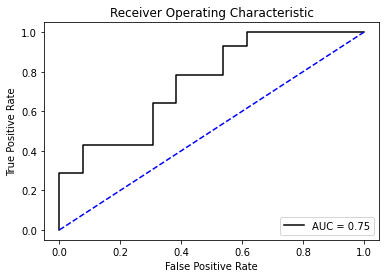

In [261]:
plot_roc_curve(tpr,fpr,AUC)

Scaling does not change the performance and is not expected to. But keep anyways.

## add hyperparameter optimization

In [78]:
n_estimators = range(100,501,50)
max_features = ['sqrt','log2',None]
min_samples_leaf = range(2,6)
max_depth = range(3,16)
min_samples_split = range(2,5)
learning_rate = np.arange(0.1,1.1,0.1)
subsample = np.arange(0.1,1.1,0.1)
criterion = ['friedman_mse','squared_error']

hyperparameters = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'learning_rate': learning_rate,
                #'subsample': subsample,
                'criterion': criterion}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 
        
model = GradientBoostingClassifier()
search = RandomizedSearchCV(estimator = model, param_distributions = hyperparameters, n_iter = 1000,  cv = cv, verbose=3, n_jobs = -1, return_train_score=True)        
search.fit(X_train_scaled, y_train_scaled)

print("best score: ", search.best_score_)
print(search.best_params_)
best_n_estimators = search.best_params_['n_estimators']
best_max_features = search.best_params_['max_features']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_max_depth = search.best_params_['max_depth']
best_min_samples_split = search.best_params_['min_samples_split']
best_learning_rate = search.best_params_['learning_rate']
best_subsample = 1 #search.best_params_['subsample']
best_criterion = search.best_params_['criterion']

gbc_hpo = GradientBoostingClassifier(n_estimators=best_n_estimators, max_features=best_max_features, 
                               min_samples_leaf=best_min_samples_leaf, 
                               max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
                               learning_rate=best_learning_rate, subsample=best_subsample, 
                               criterion=best_criterion, random_state=42)
gbc_hpo.fit(X_train_scaled, y_train_scaled)

#predict the test data
pred_train = gbc_hpo.predict(X_train_scaled)
prob_train = gbc_hpo.predict_proba(X_train_scaled)
pred = gbc_hpo.predict(X_test_scaled)
prob = gbc_hpo.predict_proba(X_test_scaled)
gbc_hpo_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
best score:  0.8777777777777779
{'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 12, 'learning_rate': 0.5, 'criterion': 'friedman_mse'}
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7407407407407407 AUC:  0.8461538461538461


In [ ]:
plot_roc_curve(tpr,fpr,AUC)

Adding Hyperparameter optimization does improve the model performance slightly.

## add PCA

In [269]:
# with hyperparameter optimization
fraction_variance = .8

#perform PCA on the training set
n_components = min(len(features), len(X_train))
pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
PCs = pca.fit_transform(X_train_scaled[features])
principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train_scaled.index)

#find the principle components that make up 80% of the varience
for j in range(len(pca.explained_variance_ratio_)):
    current_sum = pca.explained_variance_ratio_[:j].sum()
    if current_sum>=fraction_variance:
        break
print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

#apply to the test data
test_PCs = pca.transform(X_test_scaled[features])
test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test_scaled.index)

X_train_pca = principal_components[pca_features]
X_test_pca = test_principal_components[pca_features]


n_estimators = range(100,501,50) 
max_features = ['sqrt','log2',None] 
min_samples_leaf = range(2,6)
max_depth = range(3,16)
min_samples_split = range(2,5)
learning_rate = np.arange(0.1,1.1,0.1)
subsample = np.arange(0.1,1.1,0.1)
criterion = ['friedman_mse','squared_error']


hyperparameters = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'learning_rate': learning_rate,
                'subsample': subsample,
                'criterion': criterion}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 
        
model = GradientBoostingClassifier()
search = RandomizedSearchCV(estimator = model, param_distributions = hyperparameters, n_iter = 1000,  cv = cv, verbose=3, n_jobs = -1, return_train_score=True)        
search.fit(X_train_pca, y_train_scaled)

print("best score: ", search.best_score_)
print(search.best_params_)
best_n_estimators = search.best_params_['n_estimators']
best_max_features = search.best_params_['max_features']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_max_depth = search.best_params_['max_depth']
best_min_samples_split = search.best_params_['min_samples_split']
best_learning_rate = search.best_params_['learning_rate']
best_subsample = search.best_params_['subsample']
best_criterion = search.best_params_['criterion']

gbc_pca_hpo = GradientBoostingClassifier(n_estimators=best_n_estimators, max_features=best_max_features, 
                               min_samples_leaf=best_min_samples_leaf, 
                               max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
                               learning_rate=best_learning_rate, subsample=best_subsample, 
                               criterion=best_criterion, random_state=42)
gbc_pca_hpo.fit(X_train_pca, y_train_scaled)

#predict the test data
pred_train = gbc_pca_hpo.predict(X_train_pca)
prob_train = gbc_pca_hpo.predict_proba(X_train_pca)
pred = gbc_pca_hpo.predict(X_test_pca)
prob = gbc_pca_hpo.predict_proba(X_test_pca)
gbc_pca_hpo_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

total components 81 number of components: 49
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
best score:  0.7388888888888889
{'subsample': 0.7000000000000001, 'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 9, 'learning_rate': 0.2, 'criterion': 'squared_error'}
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.5555555555555556 AUC:  0.6428571428571429


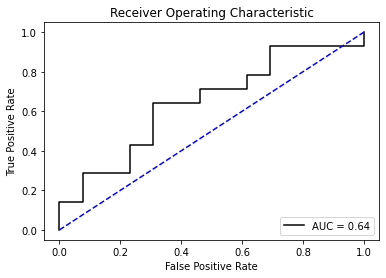

In [270]:
plot_roc_curve(tpr,fpr,AUC)

In [334]:
# with hyperparameter optimization
fraction_variance = .8

#perform PCA on the training set
n_components = min(len(features), len(X_train))
pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
PCs = pca.fit_transform(X_train_scaled[features])
principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train_scaled.index)

#find the principle components that make up 80% of the varience
for j in range(len(pca.explained_variance_ratio_)):
    current_sum = pca.explained_variance_ratio_[:j].sum()
    if current_sum>=fraction_variance:
        break
print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

#apply to the test data
test_PCs = pca.transform(X_test_scaled[features])
test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test_scaled.index)

X_train_pca = principal_components[pca_features]
X_test_pca = test_principal_components[pca_features]


gbc_pca = GradientBoostingClassifier(random_state=42)
gbc_pca.fit(X_train_pca, y_train_scaled)

#predict the test data
pred_train = gbc_pca.predict(X_train_pca)
prob_train = gbc_pca.predict_proba(X_train_pca)
pred = gbc_pca.predict(X_test_pca)
prob = gbc_pca.predict_proba(X_test_pca)
gbc_pca_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

total components 81 number of components: 49
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.6666666666666666 AUC:  0.6153846153846154


In [335]:
# without hyperparameter optimization and without scaling
fraction_variance = .8

#perform PCA on the training set
n_components = min(len(features), len(X_train))
pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
PCs = pca.fit_transform(X_train[features])
principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

#find the principle components that make up 80% of the varience
for j in range(len(pca.explained_variance_ratio_)):
    current_sum = pca.explained_variance_ratio_[:j].sum()
    if current_sum>=fraction_variance:
        break
print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

#apply to the test data
test_PCs = pca.transform(X_test[features])
test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

X_train_pca = principal_components[pca_features]
X_test_pca = test_principal_components[pca_features]

model = GradientBoostingClassifier(random_state=42)
model.fit(X_train_pca, y_train)

#predict the test data
pred_train = model.predict(X_train_pca)
prob_train = model.predict_proba(X_train_pca)
pred = model.predict(X_test_pca)
prob = model.predict_proba(X_test_pca)

# train performance
acc = accuracy_score(y_train, pred_train)
fpr,tpr,_ = roc_curve(y_train, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test, pred)
fpr,tpr,_ = roc_curve(y_test, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

total components 81 number of components: 47
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.5555555555555556 AUC:  0.6153846153846153


Adding PCA decreases model performance as for all other models. Does not seem to be good for my problem

## manual hyperparameters

In [62]:
gbc_manual = GradientBoostingClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=3, criterion='friedman_mse', subsample=1, learning_rate=0.1, random_state = 42)
gbc_manual.fit(X_train, y_train)

pred_train = gbc_manual.predict(X_train)
prob_train = gbc_manual.predict_proba(X_train)
pred = gbc_manual.predict(X_test)
prob = gbc_manual.predict_proba(X_test)
gbc_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train, pred_train)
fpr,tpr,_ = roc_curve(y_train, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test, pred)
fpr,tpr,_ = roc_curve(y_test, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)


TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7407407407407407 AUC:  0.8406593406593407


In [63]:
# with scaling
gbc_manual_scaled = GradientBoostingClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=3, criterion='friedman_mse', subsample=1, learning_rate=0.1, random_state = 42)
gbc_manual_scaled.fit(X_train_scaled, y_train_scaled)

pred_train = gbc_manual_scaled.predict(X_train_scaled)
prob_train = gbc_manual_scaled.predict_proba(X_train_scaled)
pred = gbc_manual_scaled.predict(X_test_scaled)
prob = gbc_manual_scaled.predict_proba(X_test_scaled)
gbc_manual_scaled_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7777777777777778 AUC:  0.8681318681318682


In [64]:
# with PCA
fraction_variance = .8

#perform PCA on the training set
n_components = min(len(features), len(X_train))
pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
PCs = pca.fit_transform(X_train[features])
principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

#find the principle components that make up 80% of the varience
for j in range(len(pca.explained_variance_ratio_)):
    current_sum = pca.explained_variance_ratio_[:j].sum()
    if current_sum>=fraction_variance:
        break
print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

#apply to the test data
test_PCs = pca.transform(X_test[features])
test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

X_train_pca = principal_components[pca_features]
X_test_pca = test_principal_components[pca_features]

gbc_manual = GradientBoostingClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=3, criterion='friedman_mse', subsample=1, learning_rate=0.1, random_state = 42)
gbc_manual.fit(X_train_pca, y_train)

pred_train = gbc_manual.predict(X_train_pca)
prob_train = gbc_manual.predict_proba(X_train_pca)
pred = gbc_manual.predict(X_test_pca)
prob = gbc_manual.predict_proba(X_test_pca)
#gbc_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train, pred_train)
fpr,tpr,_ = roc_curve(y_train, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test, pred)
fpr,tpr,_ = roc_curve(y_test, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)


total components 81 number of components: 47
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.5185185185185185 AUC:  0.7087912087912088


In [65]:
# with scaling and with PCA
fraction_variance = .8

#perform PCA on the training set
n_components = min(len(features), len(X_train_scaled))
pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
PCs = pca.fit_transform(X_train_scaled[features])
principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train_scaled.index)

#find the principle components that make up 80% of the varience
for j in range(len(pca.explained_variance_ratio_)):
    current_sum = pca.explained_variance_ratio_[:j].sum()
    if current_sum>=fraction_variance:
        break
print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

#apply to the test data
test_PCs = pca.transform(X_test_scaled[features])
test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test_scaled.index)

X_train_pca = principal_components[pca_features]
X_test_pca = test_principal_components[pca_features]

gbc_manual = GradientBoostingClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=3, criterion='friedman_mse', subsample=1, learning_rate=0.1, random_state = 42)
gbc_manual.fit(X_train_pca, y_train)

pred_train = gbc_manual.predict(X_train_pca)
prob_train = gbc_manual.predict_proba(X_train_pca)
pred = gbc_manual.predict(X_test_pca)
prob = gbc_manual.predict_proba(X_test_pca)
#gbc_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train, pred_train)
fpr,tpr,_ = roc_curve(y_train, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test, pred)
fpr,tpr,_ = roc_curve(y_test, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)


total components 81 number of components: 49
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.6296296296296297 AUC:  0.5549450549450549


# Compare to other results
## Compare GC / no GC

In [272]:
# params
cancer_type = "breast_cancer"
GC = "uncorrected"
score = "MIDPOINT"
amplitude = "FFT"

# cancer features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+cancer_type+"_"+GC+"_"+score+"_"+amplitude+"_features.csv"
c_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_breast_cancer_metadata.tsv"
c_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

c_features = c_features.reset_index(drop=False)
c_features[['sample','p','score']] = c_features['index'].str.split('_',2, expand=True)
c_features = c_features.set_index('sample')
cancer = pd.concat([c_features, c_meta], axis=1)

# healthy features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_"+GC+"_"+score+"_"+amplitude+"_features.csv"
h_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_metadata.tsv"
h_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

h_features = h_features.reset_index(drop=False)
h_features[['sample','p','score']] = h_features['index'].str.split('_',2, expand=True)
h_features = h_features.set_index('sample')
healthy = pd.concat([h_features, h_meta], axis=1)

# concat breast cancer and healthy
data_uncorrected = pd.concat([cancer, healthy], axis=0) #pd.concat([data1, data2], axis=0)
features_uncorrected = data_uncorrected.columns[(data_uncorrected.columns.str.startswith('central_cov')) | (data_uncorrected.columns.str.startswith('mean_cov')) | (data_uncorrected.columns.str.startswith('amplitude')) | (data_uncorrected.columns.str.startswith('nucleosome_spacing'))]

train_uncorrected,test_uncorrected = train_test_split(data_uncorrected, test_size = 0.25, random_state = 42)
X_train_uncorrected = train_uncorrected[features_uncorrected]
y_train_uncorrected = train_uncorrected.loc[:,"phenotype"]
X_test_uncorrected = test_uncorrected[features_uncorrected]
y_test_uncorrected = test_uncorrected.loc[:,"phenotype"]

scaled_data_uncorrected = pd.concat([cancer, healthy], axis=0) 
scaler = StandardScaler()
scaler.fit(scaled_data_uncorrected[features_uncorrected])
scaled_data_uncorrected[features_uncorrected] = scaler.transform(scaled_data_uncorrected[features_uncorrected])
scaled_data_uncorrected[features_uncorrected].mean()

train_scaled_uncorrected,test_scaled_uncorrected = train_test_split(scaled_data_uncorrected, test_size = 0.25, random_state = 42)
X_train_scaled_uncorrected = train_scaled_uncorrected[features_uncorrected]
y_train_scaled_uncorrected = train_scaled_uncorrected.loc[:,"phenotype"]
X_test_scaled_uncorrected = test_scaled_uncorrected[features_uncorrected]
y_test_scaled_uncorrected = test_scaled_uncorrected.loc[:,"phenotype"]

In [273]:
# RF uncorrected
n_estimators = range(100,501,50) #list [start:stop:step], np arange
max_features = ['sqrt','log2',None] #np.arange(50,251,50)
min_samples_leaf = range(2,6)
max_depth = range(3,16)
min_samples_split = range(2,5)
criterion = ['gini','entropy']

hyperparameters = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': [True,False],
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'criterion': criterion}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 
        
model = RandomForestClassifier()
search = RandomizedSearchCV(estimator = model, param_distributions = hyperparameters, n_iter = 1000,  cv = cv, verbose=3, n_jobs = -1, return_train_score=True)        
search.fit(X_train_scaled_uncorrected, y_train_scaled_uncorrected)

print("best score: ", search.best_score_)
print(search.best_params_)
best_n_estimators = search.best_params_['n_estimators']
best_max_features = search.best_params_['max_features']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_max_depth = search.best_params_['max_depth']
best_min_samples_split = search.best_params_['min_samples_split']
best_bootstrap = search.best_params_['bootstrap']
best_criterion = search.best_params_['criterion']

rf_uncorrected_hpo = RandomForestClassifier(n_estimators=best_n_estimators, max_features=best_max_features, 
                               min_samples_leaf=best_min_samples_leaf, 
                               max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
                               bootstrap=best_bootstrap, criterion=best_criterion, random_state=42)
rf_uncorrected_hpo.fit(X_train_scaled_uncorrected, y_train_scaled_uncorrected)

#predict the test data
pred_train = rf_uncorrected_hpo.predict(X_train_scaled_uncorrected)
prob_train = rf_uncorrected_hpo.predict_proba(X_train_scaled_uncorrected)
pred = rf_uncorrected_hpo.predict(X_test_scaled_uncorrected)
prob = rf_uncorrected_hpo.predict_proba(X_test_scaled_uncorrected)
rf_uncorrected_hpo_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_uncorrected, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_uncorrected, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_uncorrected, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_uncorrected, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
best score:  0.7666666666666666
{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 13, 'criterion': 'gini', 'bootstrap': True}
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.6296296296296297 AUC:  0.7857142857142857


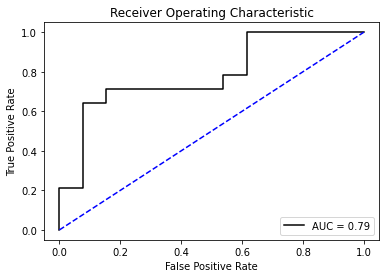

In [274]:
plot_roc_curve(tpr,fpr,AUC)

In [275]:
# RF uncorrected without hyperparameter optimization

rf_uncorrected = RandomForestClassifier(random_state=42)
rf_uncorrected.fit(X_train_scaled_uncorrected, y_train_scaled_uncorrected)

#predict the test data
pred_train = rf_uncorrected.predict(X_train_scaled_uncorrected)
prob_train = rf_uncorrected.predict_proba(X_train_scaled_uncorrected)
pred = rf_uncorrected.predict(X_test_scaled_uncorrected)
prob = rf_uncorrected.predict_proba(X_test_scaled_uncorrected)
rf_uncorrected_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_uncorrected, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_uncorrected, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_uncorrected, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_uncorrected, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7037037037037037 AUC:  0.8021978021978022


In [454]:
# RF uncorrected manual

rf_uncorrected_manual = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=8, criterion='gini', bootstrap=True, random_state = 42)
rf_uncorrected_manual.fit(X_train_scaled_uncorrected, y_train_scaled_uncorrected)

pred_train = rf_uncorrected_manual.predict(X_train_scaled_uncorrected)
prob_train = rf_uncorrected_manual.predict_proba(X_train_scaled_uncorrected)
pred = rf_uncorrected_manual.predict(X_test_scaled_uncorrected)
prob = rf_uncorrected_manual.predict_proba(X_test_scaled_uncorrected)
rf_uncorrected_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_uncorrected, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_uncorrected, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_uncorrected, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_uncorrected, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.6666666666666666 AUC:  0.7472527472527473


In [276]:
# GBC uncorrected
n_estimators = range(100,501,50) #list [start:stop:step], np arange
max_features = ['sqrt','log2',None] #np.arange(50,251,50)
min_samples_leaf = range(2,6)
max_depth = range(3,16)
min_samples_split = range(2,5)
learning_rate = np.arange(0.1,1.1,0.1)
subsample = np.arange(0.1,1.1,0.1)
criterion = ['friedman_mse','squared_error']
###### add other params?

hyperparameters = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'learning_rate': learning_rate,
                'subsample': subsample,
                'criterion': criterion}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 
        
model = GradientBoostingClassifier()
search = RandomizedSearchCV(estimator = model, param_distributions = hyperparameters, n_iter = 1000,  cv = cv, verbose=3, n_jobs = -1, return_train_score=True)        
search.fit(X_train_scaled_uncorrected, y_train_scaled_uncorrected)

print("best score: ", search.best_score_)
print(search.best_params_)
best_n_estimators = search.best_params_['n_estimators']
best_max_features = search.best_params_['max_features']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_max_depth = search.best_params_['max_depth']
best_min_samples_split = search.best_params_['min_samples_split']
best_learning_rate = search.best_params_['learning_rate']
best_subsample = search.best_params_['subsample']
best_criterion = search.best_params_['criterion']

gbc_uncorrected_hpo = GradientBoostingClassifier(n_estimators=best_n_estimators, max_features=best_max_features, 
                               min_samples_leaf=best_min_samples_leaf, 
                               max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
                               learning_rate=best_learning_rate, subsample=best_subsample, 
                               criterion=best_criterion, random_state=42)
gbc_uncorrected_hpo.fit(X_train_scaled_uncorrected, y_train_scaled_uncorrected)

#predict the test data
pred_train = gbc_uncorrected_hpo.predict(X_train_scaled_uncorrected)
prob_train = gbc_uncorrected_hpo.predict_proba(X_train_scaled_uncorrected)
pred = gbc_uncorrected_hpo.predict(X_test_scaled_uncorrected)
prob = gbc_uncorrected_hpo.predict_proba(X_test_scaled_uncorrected)
gbc_uncorrected_hpo = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_uncorrected, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_uncorrected, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_uncorrected, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_uncorrected, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
best score:  0.8125
{'subsample': 0.30000000000000004, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 4, 'learning_rate': 0.30000000000000004, 'criterion': 'squared_error'}
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.6666666666666666 AUC:  0.7747252747252747


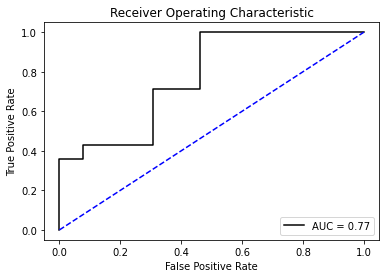

In [277]:
plot_roc_curve(tpr,fpr,AUC)

In [278]:
# GBC uncorrected without hyperparameter optimization

gbc_uncorrected = GradientBoostingClassifier(random_state=42)
gbc_uncorrected.fit(X_train_scaled_uncorrected, y_train_scaled_uncorrected)

#predict the test data
pred_train = gbc_uncorrected.predict(X_train_scaled_uncorrected)
prob_train = gbc_uncorrected.predict_proba(X_train_scaled_uncorrected)
pred = gbc_uncorrected.predict(X_test_scaled_uncorrected)
prob = gbc_uncorrected.predict_proba(X_test_scaled_uncorrected)
gbc_uncorrected = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_uncorrected, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_uncorrected, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_uncorrected, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_uncorrected, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.6666666666666666 AUC:  0.6648351648351649


In [455]:
# GBC uncorrected manual

gbc_uncorrected_manual = GradientBoostingClassifier(n_estimators=500, min_samples_split=6, min_samples_leaf=3, max_features='sqrt', 
    max_depth=3, criterion='friedman_mse', subsample=1, learning_rate=0.1, random_state = 42)
gbc_uncorrected_manual.fit(X_train_scaled_uncorrected, y_train_scaled_uncorrected)

pred_train = gbc_uncorrected_manual.predict(X_train_scaled_uncorrected)
prob_train = gbc_uncorrected_manual.predict_proba(X_train_scaled_uncorrected)
pred = gbc_uncorrected_manual.predict(X_test_scaled_uncorrected)
prob = gbc_uncorrected_manual.predict_proba(X_test_scaled_uncorrected)
gbc_uncorrected_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_uncorrected, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_uncorrected, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_uncorrected, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_uncorrected, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)


TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7037037037037037 AUC:  0.7747252747252747


## Compare feature contributions

In [291]:
features_griffin = data.columns[(data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('mean_cov')) | (data.columns.str.startswith('amplitude'))]
features_mine = data.columns[(data.columns.str.startswith('nucleosome_spacing'))]
features_mix = data.columns[(data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('mean_cov')) | (data.columns.str.startswith('nucleosome_spacing'))]


# Griffin features
X_train_griffin = train[features_griffin]
y_train_griffin = train.loc[:,"phenotype"]
X_test_griffin = test[features_griffin]
y_test_griffin = test.loc[:,"phenotype"]

## scale data
scaled_data_griffin = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_griffin[features_griffin])
scaled_data_griffin[features_griffin] = scaler.transform(scaled_data_griffin[features_griffin])
scaled_data_griffin[features_griffin].mean()

train_scaled_griffin,test_scaled_griffin = train_test_split(scaled_data_griffin, test_size = 0.25, random_state = 42)
X_train_scaled_griffin = train_scaled_griffin[features_griffin]
y_train_scaled_griffin = train_scaled_griffin.loc[:,"phenotype"]
X_test_scaled_griffin = test_scaled_griffin[features_griffin]
y_test_scaled_griffin = test_scaled_griffin.loc[:,"phenotype"]


# thesis features
X_train_mine = train[features_mine]
y_train_mine = train.loc[:,"phenotype"]
X_test_mine = test[features_mine]
y_test_mine = test.loc[:,"phenotype"]

## scale data
scaled_data_mine = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_mine[features_mine])
scaled_data_mine[features_mine] = scaler.transform(scaled_data_mine[features_mine])
scaled_data_mine[features_mine].mean()

train_scaled_mine,test_scaled_mine = train_test_split(scaled_data_mine, test_size = 0.25, random_state = 42)
X_train_scaled_mine = train_scaled_mine[features_mine]
y_train_scaled_mine = train_scaled_mine.loc[:,"phenotype"]
X_test_scaled_mine = test_scaled_mine[features_mine]
y_test_scaled_mine = test_scaled_mine.loc[:,"phenotype"]


# mix of both features
X_train_mix = train[features_mix]
y_train_mix = train.loc[:,"phenotype"]
X_test_mix = test[features_mix]
y_test_mix = test.loc[:,"phenotype"]

## scale data
scaled_data_mix = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_mix[features_mix])
scaled_data_mix[features_mix] = scaler.transform(scaled_data_mix[features_mix])
scaled_data_mix[features_mix].mean()

train_scaled_mix,test_scaled_mix = train_test_split(scaled_data_mix, test_size = 0.25, random_state = 42)
X_train_scaled_mix = train_scaled_mix[features_mix]
y_train_scaled_mix = train_scaled_mix.loc[:,"phenotype"]
X_test_scaled_mix = test_scaled_mix[features_mix]
y_test_scaled_mix = test_scaled_mix.loc[:,"phenotype"]

In [292]:
# RF Griffin features
n_estimators = range(100,501,50)
max_features = ['sqrt','log2',None]
min_samples_leaf = range(2,6)
max_depth = range(3,16)
min_samples_split = range(2,5)
criterion = ['gini','entropy']

hyperparameters = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': [True,False],
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'criterion': criterion}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 
        
model = RandomForestClassifier()
search = RandomizedSearchCV(estimator = model, param_distributions = hyperparameters, n_iter = 1000,  cv = cv, verbose=3, n_jobs = -1, return_train_score=True)        
search.fit(X_train_scaled_griffin, y_train_scaled_griffin)

print("best score: ", search.best_score_)
print(search.best_params_)
best_n_estimators = search.best_params_['n_estimators']
best_max_features = search.best_params_['max_features']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_max_depth = search.best_params_['max_depth']
best_min_samples_split = search.best_params_['min_samples_split']
best_bootstrap = search.best_params_['bootstrap']
best_criterion = search.best_params_['criterion']

rf_griffin_hpo = RandomForestClassifier(n_estimators=best_n_estimators, max_features=best_max_features, 
                               min_samples_leaf=best_min_samples_leaf, 
                               max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
                               bootstrap=best_bootstrap, criterion=best_criterion, random_state=42)
rf_griffin_hpo.fit(X_train_scaled_griffin, y_train_scaled_griffin)

predict_train = rf_griffin_hpo.predict(X_train_scaled_griffin)
predict_test = rf_griffin_hpo.predict(X_test_scaled_griffin)
probability_test = rf_griffin_hpo.predict_proba(X_test_scaled_griffin)

acc = accuracy_score(y_test_scaled_griffin, predict_test)
fpr,tpr,_ = roc_curve(y_test_scaled_griffin, probability_test[:,1])
AUC = auc(fpr,tpr)
rf_griffin_hpo_prob = probability_test[:,1]
print('Accuracy: ', acc, 'AUC: ', AUC)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
best score:  0.8625
{'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'gini', 'bootstrap': False}
Accuracy:  0.7777777777777778 AUC:  0.8021978021978022


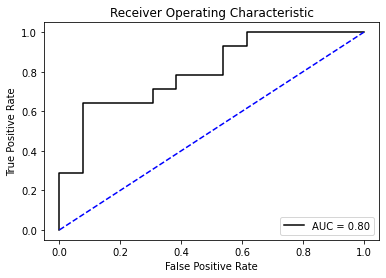

In [293]:
plot_roc_curve(tpr,fpr,AUC)

In [294]:
# GBC Griffin features
n_estimators = range(100,501,50) 
max_features = ['sqrt','log2',None] 
min_samples_leaf = range(2,6)
max_depth = range(3,16)
min_samples_split = range(2,5)
learning_rate = np.arange(0.1,1.1,0.1)
subsample = np.arange(0.1,1.1,0.1)
criterion = ['friedman_mse','squared_error']

hyperparameters = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'learning_rate': learning_rate,
                'subsample': subsample,
                'criterion': criterion}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 
        
model = GradientBoostingClassifier()
search = RandomizedSearchCV(estimator = model, param_distributions = hyperparameters, n_iter = 1000,  cv = cv, verbose=3, n_jobs = -1, return_train_score=True)        
search.fit(X_train_scaled_griffin, y_train_scaled_griffin)

print("best score: ", search.best_score_)
print(search.best_params_)
best_n_estimators = search.best_params_['n_estimators']
best_max_features = search.best_params_['max_features']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_max_depth = search.best_params_['max_depth']
best_min_samples_split = search.best_params_['min_samples_split']
best_learning_rate = search.best_params_['learning_rate']
best_subsample = search.best_params_['subsample']
best_criterion = search.best_params_['criterion']

gbc_griffin_hpo = GradientBoostingClassifier(n_estimators=best_n_estimators, max_features=best_max_features, 
                               min_samples_leaf=best_min_samples_leaf, 
                               max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
                               learning_rate=best_learning_rate, subsample=best_subsample, 
                               criterion=best_criterion, random_state=42)
gbc_griffin_hpo.fit(X_train_scaled_griffin, y_train_scaled_griffin)

predict_train = gbc_griffin_hpo.predict(X_train_scaled_griffin)
predict_test = gbc_griffin_hpo.predict(X_test_scaled_griffin)
probability_test = gbc_griffin_hpo.predict_proba(X_test_scaled_griffin)

acc = accuracy_score(y_test_scaled_griffin, predict_test)
fpr,tpr,_ = roc_curve(y_test_scaled_griffin, probability_test[:,1])
AUC = auc(fpr,tpr)
gbc_griffin_hpo_prob = probability_test[:,1]
print('Accuracy: ', acc, 'AUC: ', AUC)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
best score:  0.851388888888889
{'subsample': 1.0, 'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.4, 'criterion': 'friedman_mse'}
Accuracy:  0.7407407407407407 AUC:  0.8516483516483517


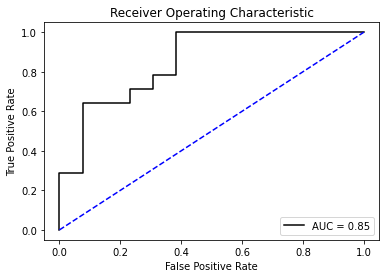

In [295]:
plot_roc_curve(tpr,fpr,AUC)

In [296]:
# RF thesis features
n_estimators = range(100,501,50) 
max_features = ['sqrt','log2',None] 
min_samples_leaf = range(2,6)
max_depth = range(3,16)
min_samples_split = range(2,5)
criterion = ['gini','entropy']

hyperparameters = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': [True,False],
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'criterion': criterion}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 
        
model = RandomForestClassifier()
search = RandomizedSearchCV(estimator = model, param_distributions = hyperparameters, n_iter = 1000,  cv = cv, verbose=3, n_jobs = -1, return_train_score=True)        
search.fit(X_train_scaled_mine, y_train_scaled_mine)

print("best score: ", search.best_score_)
print(search.best_params_)
best_n_estimators = search.best_params_['n_estimators']
best_max_features = search.best_params_['max_features']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_max_depth = search.best_params_['max_depth']
best_min_samples_split = search.best_params_['min_samples_split']
best_bootstrap = search.best_params_['bootstrap']
best_criterion = search.best_params_['criterion']

rf_mine_hpo = RandomForestClassifier(n_estimators=best_n_estimators, max_features=best_max_features, 
                               min_samples_leaf=best_min_samples_leaf, 
                               max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
                               bootstrap=best_bootstrap, criterion=best_criterion, random_state=42)
rf_mine_hpo.fit(X_train_scaled_mine, y_train_scaled_mine)

predict_train = rf_mine_hpo.predict(X_train_scaled_mine)
predict_test = rf_mine_hpo.predict(X_test_scaled_mine)
probability_test = rf_mine_hpo.predict_proba(X_test_scaled_mine)

accuracy_score(y_test_scaled_mine, predict_test)

acc = accuracy_score(y_test_scaled_mine, predict_test)
fpr,tpr,_ = roc_curve(y_test_scaled_mine, probability_test[:,1])
AUC = auc(fpr,tpr)
rf_mine_hpo_prob = probability_test[:,1]
print('Accuracy: ', acc, 'AUC: ', AUC)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
best score:  0.7416666666666666
{'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
Accuracy:  0.5185185185185185 AUC:  0.6318681318681318


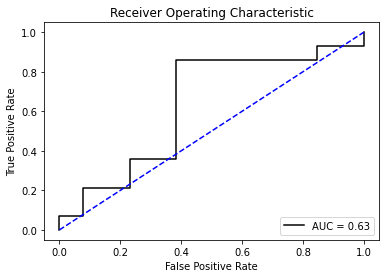

In [297]:
plot_roc_curve(tpr,fpr,AUC)

In [298]:
# GBC thesis features
n_estimators = range(100,501,50) 
max_features = ['sqrt','log2',None] 
min_samples_leaf = range(2,6)
max_depth = range(3,16)
min_samples_split = range(2,5)
learning_rate = np.arange(0.1,1.1,0.1)
subsample = np.arange(0.1,1.1,0.1)
criterion = ['friedman_mse','squared_error']

hyperparameters = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'learning_rate': learning_rate,
                'subsample': subsample,
                'criterion': criterion}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 
        
model = GradientBoostingClassifier()
search = RandomizedSearchCV(estimator = model, param_distributions = hyperparameters, n_iter = 1000,  cv = cv, verbose=3, n_jobs = -1, return_train_score=True)        
search.fit(X_train_scaled_mine, y_train_scaled_mine)

print("best score: ", search.best_score_)
print(search.best_params_)
best_n_estimators = search.best_params_['n_estimators']
best_max_features = search.best_params_['max_features']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_max_depth = search.best_params_['max_depth']
best_min_samples_split = search.best_params_['min_samples_split']
best_learning_rate = search.best_params_['learning_rate']
best_subsample = search.best_params_['subsample']
best_criterion = search.best_params_['criterion']

gbc_mine_hpo = GradientBoostingClassifier(n_estimators=best_n_estimators, max_features=best_max_features, 
                               min_samples_leaf=best_min_samples_leaf, 
                               max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
                               learning_rate=best_learning_rate, subsample=best_subsample, 
                               criterion=best_criterion, random_state=42)
gbc_mine_hpo.fit(X_train_scaled_mine, y_train_scaled_mine)

predict_train = gbc_mine_hpo.predict(X_train_scaled_mine)
predict_test = gbc_mine_hpo.predict(X_test_scaled_mine)
probability_test = gbc_mine_hpo.predict_proba(X_test_scaled_mine)

accuracy_score(y_test_scaled_mine, predict_test)

acc = accuracy_score(y_test_scaled_mine, predict_test)
fpr,tpr,_ = roc_curve(y_test_scaled_mine, probability_test[:,1])
AUC = auc(fpr,tpr)
gbc_mine_hpo_prob = probability_test[:,1]
print('Accuracy: ', acc, 'AUC: ', AUC)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
best score:  0.7277777777777777
{'subsample': 1.0, 'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 1.0, 'criterion': 'friedman_mse'}
Accuracy:  0.5925925925925926 AUC:  0.6538461538461539


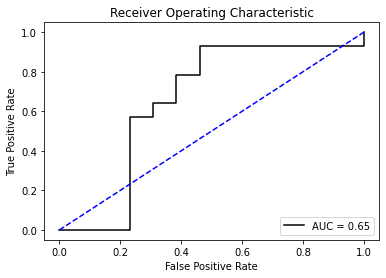

In [299]:
plot_roc_curve(tpr,fpr,AUC)

In [300]:
# RF mix features
n_estimators = range(100,501,50) 
max_features = ['sqrt','log2',None]
min_samples_leaf = range(2,6)
max_depth = range(3,16)
min_samples_split = range(2,5)
criterion = ['gini','entropy']

hyperparameters = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': [True,False],
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'criterion': criterion}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 
        
model = RandomForestClassifier()
search = RandomizedSearchCV(estimator = model, param_distributions = hyperparameters, n_iter = 1000,  cv = cv, verbose=3, n_jobs = -1, return_train_score=True)        
search.fit(X_train_scaled_mix, y_train_scaled_mix)

print("best score: ", search.best_score_)
print(search.best_params_)
best_n_estimators = search.best_params_['n_estimators']
best_max_features = search.best_params_['max_features']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_max_depth = search.best_params_['max_depth']
best_min_samples_split = search.best_params_['min_samples_split']
best_bootstrap = search.best_params_['bootstrap']
best_criterion = search.best_params_['criterion']

rf_mix_hpo = RandomForestClassifier(n_estimators=best_n_estimators, max_features=best_max_features, 
                               min_samples_leaf=best_min_samples_leaf, 
                               max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
                               bootstrap=best_bootstrap, criterion=best_criterion, random_state=42)
rf_mix_hpo.fit(X_train_scaled_mix, y_train_scaled_mix)

predict_train = rf_mix_hpo.predict(X_train_scaled_mix)
predict_test = rf_mix_hpo.predict(X_test_scaled_mix)
probability_test = rf_mix_hpo.predict_proba(X_test_scaled_mix)

acc = accuracy_score(y_test_scaled_mix, predict_test)
fpr,tpr,_ = roc_curve(y_test_scaled_mix, probability_test[:,1])
AUC = auc(fpr,tpr)
rf_mix_hpo_prob = probability_test[:,1]
print('Accuracy: ', acc, 'AUC: ', AUC)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
best score:  0.851388888888889
{'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 11, 'criterion': 'entropy', 'bootstrap': False}
Accuracy:  0.7777777777777778 AUC:  0.8461538461538463


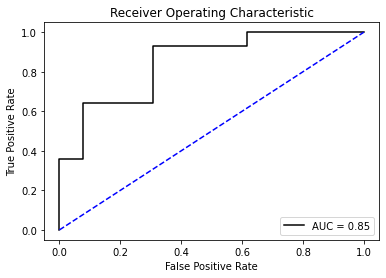

In [301]:
plot_roc_curve(tpr,fpr,AUC)

In [302]:
# GBC mix features
n_estimators = range(100,501,50) 
max_features = ['sqrt','log2',None] 
min_samples_leaf = range(2,6)
max_depth = range(3,16)
min_samples_split = range(2,5)
learning_rate = np.arange(0.1,1.1,0.1)
subsample = np.arange(0.1,1.1,0.1)
criterion = ['friedman_mse','squared_error']
###### add other params?

hyperparameters = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'learning_rate': learning_rate,
                'subsample': subsample,
                'criterion': criterion}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 
        
model = GradientBoostingClassifier()
search = RandomizedSearchCV(estimator = model, param_distributions = hyperparameters, n_iter = 1000,  cv = cv, verbose=3, n_jobs = -1, return_train_score=True)        
search.fit(X_train_scaled_mix, y_train_scaled_mix)

print("best score: ", search.best_score_)
print(search.best_params_)
best_n_estimators = search.best_params_['n_estimators']
best_max_features = search.best_params_['max_features']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_max_depth = search.best_params_['max_depth']
best_min_samples_split = search.best_params_['min_samples_split']
best_learning_rate = search.best_params_['learning_rate']
best_subsample = search.best_params_['subsample']
best_criterion = search.best_params_['criterion']

gbc_mix_hpo = GradientBoostingClassifier(n_estimators=best_n_estimators, max_features=best_max_features, 
                               min_samples_leaf=best_min_samples_leaf, 
                               max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
                               learning_rate=best_learning_rate, subsample=best_subsample, 
                               criterion=best_criterion, random_state=42)
gbc_mix_hpo.fit(X_train_scaled_mix, y_train_scaled_mix)

predict_train = gbc_mix_hpo.predict(X_train_scaled_mix)
predict_test = gbc_mix_hpo.predict(X_test_scaled_mix)
probability_test = gbc_mix_hpo.predict_proba(X_test_scaled_mix)

acc = accuracy_score(y_test_scaled_mix, predict_test)
fpr,tpr,_ = roc_curve(y_test_scaled_mix, probability_test[:,1])
AUC = auc(fpr,tpr)
gbc_mix_hpo_prob = probability_test[:,1]
print('Accuracy: ', acc, 'AUC: ', AUC)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
best score:  0.8527777777777779
{'subsample': 0.7000000000000001, 'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.2, 'criterion': 'friedman_mse'}
Accuracy:  0.7037037037037037 AUC:  0.8131868131868132


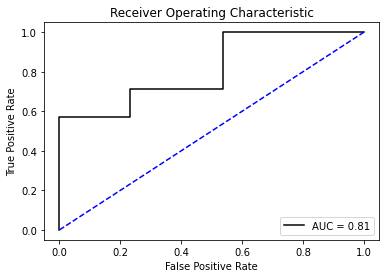

In [303]:
plot_roc_curve(tpr,fpr,AUC)

Results of RF with all 4 features: 
Results of RF with only Griffin features: 
Results of RF with only my feature: 

Conclusion:


## compare feature contributions without hyperparameter optimization

In [457]:
# RF Griffin features default
rf_griffin = RandomForestClassifier(random_state=42)
rf_griffin.fit(X_train_scaled_griffin, y_train_scaled_griffin)

#predict the test data
pred_train = rf_griffin.predict(X_train_scaled_griffin)
prob_train = rf_griffin.predict_proba(X_train_scaled_griffin)
pred = rf_griffin.predict(X_test_scaled_griffin)
prob = rf_griffin.predict_proba(X_test_scaled_griffin)
rf_griffin_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_griffin, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_griffin, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_griffin, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_griffin, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.6296296296296297 AUC:  0.75


In [458]:
# RF Griffin features manual
rf_griffin_manual = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=8, criterion='gini', bootstrap=True, random_state = 42)
rf_griffin_manual.fit(X_train_scaled_griffin, y_train_scaled_griffin)

pred_train = rf_griffin_manual.predict(X_train_scaled_griffin)
prob_train = rf_griffin_manual.predict_proba(X_train_scaled_griffin)
pred = rf_griffin_manual.predict(X_test_scaled_griffin)
prob = rf_griffin_manual.predict_proba(X_test_scaled_griffin)
rf_griffin_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_griffin, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_griffin, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_griffin, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_griffin, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.6666666666666666 AUC:  0.8076923076923077


In [459]:
# GBC Griffin features default
gbc_griffin = GradientBoostingClassifier(random_state=42)
gbc_griffin.fit(X_train_scaled_griffin, y_train_scaled_griffin)

#predict the test data
pred_train = gbc_griffin.predict(X_train_scaled_griffin)
prob_train = gbc_griffin.predict_proba(X_train_scaled_griffin)
pred = gbc_griffin.predict(X_test_scaled_griffin)
prob = gbc_griffin.predict_proba(X_test_scaled_griffin)
gbc_griffin_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_griffin, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_griffin, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_griffin, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_griffin, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7037037037037037 AUC:  0.7637362637362637


In [460]:
# GBC Griffin features manual
gbc_griffin_manual = GradientBoostingClassifier(n_estimators=500, min_samples_split=6, min_samples_leaf=3, max_features='sqrt', 
    max_depth=3, criterion='friedman_mse', subsample=1, learning_rate=0.1, random_state = 42)
gbc_griffin_manual.fit(X_train_scaled_griffin, y_train_scaled_griffin)

pred_train = gbc_griffin_manual.predict(X_train_scaled_griffin)
prob_train = gbc_griffin_manual.predict_proba(X_train_scaled_griffin)
pred = gbc_griffin_manual.predict(X_test_scaled_griffin)
prob = gbc_griffin_manual.predict_proba(X_test_scaled_griffin)
gbc_griffin_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_griffin, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_griffin, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_griffin, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_griffin, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)


TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7777777777777778 AUC:  0.8626373626373627


In [461]:
# RF my features default
rf_mine = RandomForestClassifier(random_state=42)
rf_mine.fit(X_train_scaled_mine, y_train_scaled_mine)

#predict the test data
pred_train = rf_mine.predict(X_train_scaled_mine)
prob_train = rf_mine.predict_proba(X_train_scaled_mine)
pred = rf_mine.predict(X_test_scaled_mine)
prob = rf_mine.predict_proba(X_test_scaled_mine)
rf_mine_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_mine, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_mine, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_mine, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_mine, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.5555555555555556 AUC:  0.5796703296703296


In [462]:
rf_mine_manual = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=8, criterion='gini', bootstrap=True, random_state = 42)
rf_mine_manual.fit(X_train_scaled_mine, y_train_scaled_mine)

pred_train = rf_mine_manual.predict(X_train_scaled_mine)
prob_train = rf_mine_manual.predict_proba(X_train_scaled_mine)
pred = rf_mine_manual.predict(X_test_scaled_mine)
prob = rf_mine_manual.predict_proba(X_test_scaled_mine)
rf_mine_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_mine, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_mine, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_mine, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_mine, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.6296296296296297 AUC:  0.6868131868131868


In [463]:
# GBC my features default
gbc_mine = GradientBoostingClassifier(random_state=42)
gbc_mine.fit(X_train_scaled_mine, y_train_scaled_mine)

#predict the test data
pred_train = gbc_mine.predict(X_train_scaled_mine)
prob_train = gbc_mine.predict_proba(X_train_scaled_mine)
pred = gbc_mine.predict(X_test_scaled_mine)
prob = gbc_mine.predict_proba(X_test_scaled_mine)
gbc_mine_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_mine, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_mine, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_mine, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_mine, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.5555555555555556 AUC:  0.6978021978021978


In [464]:
# GBC my features manual
gbc_mine_manual = GradientBoostingClassifier(n_estimators=500, min_samples_split=6, min_samples_leaf=3, max_features='sqrt', 
    max_depth=3, criterion='friedman_mse', subsample=1, learning_rate=0.1, random_state = 42)
gbc_mine_manual.fit(X_train_scaled_mine, y_train_scaled_mine)

pred_train = gbc_mine_manual.predict(X_train_scaled_mine)
prob_train = gbc_mine_manual.predict_proba(X_train_scaled_mine)
pred = gbc_mine_manual.predict(X_test_scaled_mine)
prob = gbc_mine_manual.predict_proba(X_test_scaled_mine)
gbc_mine_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_mine, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_mine, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_mine, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_mine, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)


TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.6296296296296297 AUC:  0.7417582417582418


In [465]:
# RF mix features default
rf_mix = RandomForestClassifier(random_state=42)
rf_mix.fit(X_train_scaled_mix, y_train_scaled_mix)

#predict the test data
pred_train = rf_mix.predict(X_train_scaled_mix)
prob_train = rf_mix.predict_proba(X_train_scaled_mix)
pred = rf_mix.predict(X_test_scaled_mix)
prob = rf_mix.predict_proba(X_test_scaled_mix)
rf_mix_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_mix, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_mix, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_mix, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_mix, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.5925925925925926 AUC:  0.7335164835164836


In [466]:
# RF mix features manual
rf_mix_manual = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=8, criterion='gini', bootstrap=True, random_state = 42)
rf_mix_manual.fit(X_train_scaled_mix, y_train_scaled_mix)

pred_train = rf_mix_manual.predict(X_train_scaled_mix)
prob_train = rf_mix_manual.predict_proba(X_train_scaled_mix)
pred = rf_mix_manual.predict(X_test_scaled_mix)
prob = rf_mix_manual.predict_proba(X_test_scaled_mix)
rf_mix_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_mix, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_mix, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_mix, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_mix, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.6666666666666666 AUC:  0.7857142857142858


In [467]:
# GBC mix features default
gbc_mix = GradientBoostingClassifier(random_state=42)
gbc_mix.fit(X_train_scaled_mix, y_train_scaled_mix)

#predict the test data
pred_train = gbc_mix.predict(X_train_scaled_mix)
prob_train = gbc_mix.predict_proba(X_train_scaled_mix)
pred = gbc_mix.predict(X_test_scaled_mix)
prob = gbc_mix.predict_proba(X_test_scaled_mix)
gbc_mix_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_mix, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_mix, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_mix, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_mix, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.6296296296296297 AUC:  0.7362637362637363


In [468]:
# GBC mix features manual
gbc_mix_manual = GradientBoostingClassifier(n_estimators=500, min_samples_split=6, min_samples_leaf=3, max_features='sqrt', 
    max_depth=3, criterion='friedman_mse', subsample=1, learning_rate=0.1, random_state = 42)
gbc_mix_manual.fit(X_train_scaled_mix, y_train_scaled_mix)

pred_train = gbc_mix_manual.predict(X_train_scaled_mix)
prob_train = gbc_mix_manual.predict_proba(X_train_scaled_mix)
pred = gbc_mix_manual.predict(X_test_scaled_mix)
prob = gbc_mix_manual.predict_proba(X_test_scaled_mix)
gbc_mix_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_mix, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_mix, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_mix, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_mix, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)


TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7407407407407407 AUC:  0.8351648351648352


# single features

In [545]:
#features_griffin = data.columns[(data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('mean_cov')) | (data.columns.str.startswith('amplitude'))]
feature_amplitude = data.columns[(data.columns.str.startswith('amplitude'))]
feature_central = data.columns[(data.columns.str.startswith('central_cov'))]
feature_mean = data.columns[(data.columns.str.startswith('mean_cov'))]

#scale data amplitude
scaled_data_amplitude = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_amplitude[feature_amplitude])
scaled_data_amplitude[feature_amplitude] = scaler.transform(scaled_data_amplitude[feature_amplitude])
scaled_data_amplitude[feature_amplitude].mean()
train_scaled_amplitude,test_scaled_amplitude = train_test_split(scaled_data_amplitude, test_size = 0.25, random_state = 42)
X_train_scaled_amplitude = train_scaled_amplitude[feature_amplitude]
y_train_scaled_amplitude = train_scaled_amplitude.loc[:,"phenotype"]
X_test_scaled_amplitude = test_scaled_amplitude[feature_amplitude]
y_test_scaled_amplitude = test_scaled_amplitude.loc[:,"phenotype"]

#scale data central
scaled_data_central = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_central[feature_central])
scaled_data_central[feature_central] = scaler.transform(scaled_data_central[feature_central])
scaled_data_central[feature_central].mean()
train_scaled_central,test_scaled_central = train_test_split(scaled_data_central, test_size = 0.25, random_state = 42)
X_train_scaled_central = train_scaled_central[feature_central]
y_train_scaled_central = train_scaled_central.loc[:,"phenotype"]
X_test_scaled_central = test_scaled_central[feature_central]
y_test_scaled_central = test_scaled_central.loc[:,"phenotype"]

#scale data mean
scaled_data_mean = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_mean[feature_mean])
scaled_data_mean[feature_mean] = scaler.transform(scaled_data_mean[feature_mean])
scaled_data_mean[feature_mean].mean()
train_scaled_mean,test_scaled_mean = train_test_split(scaled_data_mean, test_size = 0.25, random_state = 42)
X_train_scaled_mean = train_scaled_mean[feature_mean]
y_train_scaled_mean = train_scaled_mean.loc[:,"phenotype"]
X_test_scaled_mean = test_scaled_mean[feature_mean]
y_test_scaled_mean = test_scaled_mean.loc[:,"phenotype"]

In [555]:
# RF amplitude manual
rf_amplitude_manual = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=8, criterion='gini', bootstrap=True, random_state = 42)
rf_amplitude_manual.fit(X_train_scaled_amplitude, y_train_scaled_amplitude)

pred_train = rf_amplitude_manual.predict(X_train_scaled_amplitude)
prob_train = rf_amplitude_manual.predict_proba(X_train_scaled_amplitude)
pred = rf_amplitude_manual.predict(X_test_scaled_amplitude)
prob = rf_amplitude_manual.predict_proba(X_test_scaled_amplitude)
rf_amplitude_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_amplitude, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_amplitude, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_amplitude, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_amplitude, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7777777777777778 AUC:  0.8296703296703297


In [546]:
# GBC amplitude manual
gbc_amplitude_manual = GradientBoostingClassifier(n_estimators=500, min_samples_split=6, min_samples_leaf=3, max_features='sqrt', 
    max_depth=3, criterion='friedman_mse', subsample=1, learning_rate=0.1, random_state = 42)
gbc_amplitude_manual.fit(X_train_scaled_amplitude, y_train_scaled_amplitude)

pred_train = gbc_amplitude_manual.predict(X_train_scaled_amplitude)
prob_train = gbc_amplitude_manual.predict_proba(X_train_scaled_amplitude)
pred = gbc_amplitude_manual.predict(X_test_scaled_amplitude)
prob = gbc_amplitude_manual.predict_proba(X_test_scaled_amplitude)
gbc_amplitude_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_amplitude, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_amplitude, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_amplitude, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_amplitude, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)


TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7407407407407407 AUC:  0.8076923076923077


In [556]:
# RF central manual
rf_central_manual = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=8, criterion='gini', bootstrap=True, random_state = 42)
rf_central_manual.fit(X_train_scaled_central, y_train_scaled_central)

pred_train = rf_central_manual.predict(X_train_scaled_central)
prob_train = rf_central_manual.predict_proba(X_train_scaled_central)
pred = rf_central_manual.predict(X_test_scaled_central)
prob = rf_central_manual.predict_proba(X_test_scaled_central)
rf_central_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_central, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_central, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_central, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_central, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.6666666666666666 AUC:  0.7912087912087913


In [547]:
# GBC central manual
gbc_central_manual = GradientBoostingClassifier(n_estimators=500, min_samples_split=6, min_samples_leaf=3, max_features='sqrt', 
    max_depth=3, criterion='friedman_mse', subsample=1, learning_rate=0.1, random_state = 42)
gbc_central_manual.fit(X_train_scaled_central, y_train_scaled_central)

pred_train = gbc_central_manual.predict(X_train_scaled_central)
prob_train = gbc_central_manual.predict_proba(X_train_scaled_central)
pred = gbc_central_manual.predict(X_test_scaled_central)
prob = gbc_central_manual.predict_proba(X_test_scaled_central)
gbc_central_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_central, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_central, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_central, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_central, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)


TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7037037037037037 AUC:  0.8296703296703297


In [557]:
# RF mean manual
rf_mean_manual = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=8, criterion='gini', bootstrap=True, random_state = 42)
rf_mean_manual.fit(X_train_scaled_mean, y_train_scaled_mean)

pred_train = rf_mean_manual.predict(X_train_scaled_mean)
prob_train = rf_mean_manual.predict_proba(X_train_scaled_mean)
pred = rf_mean_manual.predict(X_test_scaled_mean)
prob = rf_mean_manual.predict_proba(X_test_scaled_mean)
rf_mean_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_mean, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_mean, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_mean, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_mean, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.5555555555555556 AUC:  0.5714285714285714


In [548]:
# GBC mean manual
gbc_mean_manual = GradientBoostingClassifier(n_estimators=500, min_samples_split=6, min_samples_leaf=3, max_features='sqrt', 
    max_depth=3, criterion='friedman_mse', subsample=1, learning_rate=0.1, random_state = 42)
gbc_mean_manual.fit(X_train_scaled_mean, y_train_scaled_mean)

pred_train = gbc_mean_manual.predict(X_train_scaled_mean)
prob_train = gbc_mean_manual.predict_proba(X_train_scaled_mean)
pred = gbc_mean_manual.predict(X_test_scaled_mean)
prob = gbc_mean_manual.predict_proba(X_test_scaled_mean)
gbc_mean_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_mean, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_mean, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_mean, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_mean, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)


TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.5555555555555556 AUC:  0.6098901098901098


In [549]:
features_mix_new = data.columns[(data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('amplitude'))]

#scale data amplitude
scaled_data_mix_new = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_mix_new[features_mix_new])
scaled_data_mix_new[features_mix_new] = scaler.transform(scaled_data_amplitude[features_mix_new])
scaled_data_mix_new[features_mix_new].mean()
train_scaled_mix_new,test_scaled_mix_new = train_test_split(scaled_data_mix_new, test_size = 0.25, random_state = 42)
X_train_scaled_mix_new = train_scaled_mix_new[features_mix_new]
y_train_scaled_mix_new = train_scaled_mix_new.loc[:,"phenotype"]
X_test_scaled_mix_new = test_scaled_mix_new[features_mix_new]
y_test_scaled_mix_new = test_scaled_mix_new.loc[:,"phenotype"]

# GBC mean manual
gbc_mix_new = GradientBoostingClassifier(n_estimators=500, min_samples_split=6, min_samples_leaf=3, max_features='sqrt', 
    max_depth=3, criterion='friedman_mse', subsample=1, learning_rate=0.1, random_state = 42)
gbc_mix_new.fit(X_train_scaled_mix_new, y_train_scaled_mix_new)

pred_train = gbc_mix_new.predict(X_train_scaled_mix_new)
prob_train = gbc_mix_new.predict_proba(X_train_scaled_mix_new)
pred = gbc_mix_new.predict(X_test_scaled_mix_new)
prob = gbc_mix_new.predict_proba(X_test_scaled_mix_new)
gbc_mix_new_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_mix_new, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_mix_new, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_mix_new, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_mix_new, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)


TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7407407407407407 AUC:  0.8351648351648352


# Compare to other scores
## Results WPS

In [310]:
# params
cancer_type = "breast_cancer"
GC = "corrected"
score = "WPS"
amplitude = "FFT"

# cancer features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+cancer_type+"_"+GC+"_"+score+"_"+amplitude+"_features.csv"
c_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_breast_cancer_metadata.tsv"
c_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

c_features = c_features.reset_index(drop=False)
c_features[['sample','p','score']] = c_features['index'].str.split('_',2, expand=True)
c_features = c_features.set_index('sample')
cancer = pd.concat([c_features, c_meta], axis=1)

# healthy features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_"+GC+"_"+score+"_"+amplitude+"_features.csv"
h_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_metadata.tsv"
h_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

h_features = h_features.reset_index(drop=False)
h_features[['sample','p','score']] = h_features['index'].str.split('_',2, expand=True)
h_features = h_features.set_index('sample')
healthy = pd.concat([h_features, h_meta], axis=1)

# concat breast cancer and healthy
data_wps = pd.concat([cancer, healthy], axis=0)
features_wps = data_wps.columns[(data_wps.columns.str.startswith('central_cov')) | (data_wps.columns.str.startswith('mean_cov')) | (data_wps.columns.str.startswith('amplitude')) | (data_wps.columns.str.startswith('nucleosome_spacing'))]

train_wps,test_wps = train_test_split(data_wps, test_size = 0.25, random_state = 42)
X_train_wps = train_wps[features_wps]
y_train_wps = train_wps.loc[:,"phenotype"]
X_test_wps = test_wps[features_wps]
y_test_wps = test_wps.loc[:,"phenotype"]

scaled_data_wps = pd.concat([cancer, healthy], axis=0) 
scaler = StandardScaler()
scaler.fit(scaled_data_wps[features_wps])
scaled_data_wps[features_wps] = scaler.transform(scaled_data_wps[features_wps])
scaled_data_wps[features_wps].mean()

train_scaled_wps,test_scaled_wps = train_test_split(scaled_data_wps, test_size = 0.25, random_state = 42)
X_train_scaled_wps = train_scaled_wps[features_wps]
y_train_scaled_wps = train_scaled_wps.loc[:,"phenotype"]
X_test_scaled_wps = test_scaled_wps[features_wps]
y_test_scaled_wps = test_scaled_wps.loc[:,"phenotype"]

In [311]:
# RF WPS
n_estimators = range(100,501,50) 
max_features = ['sqrt','log2',None] 
min_samples_leaf = range(2,6)
max_depth = range(3,16)
min_samples_split = range(2,5)
criterion = ['gini','entropy']

hyperparameters = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': [True,False],
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'criterion': criterion}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 
        
model = RandomForestClassifier()
search = RandomizedSearchCV(estimator = model, param_distributions = hyperparameters, n_iter = 1000,  cv = cv, verbose=3, n_jobs = -1, return_train_score=True)        
search.fit(X_train_scaled_wps, y_train_scaled_wps)

print("best score: ", search.best_score_)
print(search.best_params_)
best_n_estimators = search.best_params_['n_estimators']
best_max_features = search.best_params_['max_features']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_max_depth = search.best_params_['max_depth']
best_min_samples_split = search.best_params_['min_samples_split']
best_bootstrap = search.best_params_['bootstrap']
best_criterion = search.best_params_['criterion']

rf_wps_hpo = RandomForestClassifier(n_estimators=best_n_estimators, max_features=best_max_features, 
                               min_samples_leaf=best_min_samples_leaf, 
                               max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
                               bootstrap=best_bootstrap, criterion=best_criterion, random_state=42)
rf_wps_hpo.fit(X_train_scaled_wps, y_train_scaled_wps)

#predict the test data
pred_train = rf_wps_hpo.predict(X_train_scaled_wps)
prob_train = rf_wps_hpo.predict_proba(X_train_scaled_wps)
pred = rf_wps_hpo.predict(X_test_scaled_wps)
prob = rf_wps_hpo.predict_proba(X_test_scaled_wps)
rf_wps_hpo_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_wps, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_wps, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_wps, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_wps, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
best score:  0.8152777777777779
{'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': False}
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.8148148148148148 AUC:  0.9230769230769231


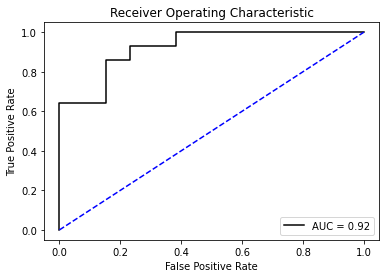

In [312]:
plot_roc_curve(tpr,fpr,AUC)

In [313]:
# RF WPS without hyperparameter optimization default

rf_wps = RandomForestClassifier(random_state=42)
rf_wps.fit(X_train_scaled_wps, y_train_scaled_wps)

#predict the test data
pred_train = rf_wps.predict(X_train_scaled_wps)
prob_train = rf_wps.predict_proba(X_train_scaled_wps)
pred = rf_wps.predict(X_test_scaled_wps)
prob = rf_wps.predict_proba(X_test_scaled_wps)
rf_wps_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_wps, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_wps, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_wps, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_wps, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.8148148148148148 AUC:  0.9368131868131868


In [469]:
# RF WPS without hyperparameter optimization manual

rf_wps_manual = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=8, criterion='gini', bootstrap=True, random_state = 42)
rf_wps_manual.fit(X_train_scaled_wps, y_train_scaled_wps)

pred_train = rf_wps_manual.predict(X_train_scaled_wps)
prob_train = rf_wps_manual.predict_proba(X_train_scaled_wps)
pred = rf_wps_manual.predict(X_test_scaled_wps)
prob = rf_wps_manual.predict_proba(X_test_scaled_wps)
rf_wps_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_wps, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_wps, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_wps, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_wps, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7407407407407407 AUC:  0.9340659340659341


In [314]:
# GBC WPS
n_estimators = range(100,501,50)
max_features = ['sqrt','log2',None]
min_samples_leaf = range(2,6)
max_depth = range(3,16)
min_samples_split = range(2,5)
learning_rate = np.arange(0.1,1.1,0.1)
subsample = np.arange(0.1,1.1,0.1)
criterion = ['friedman_mse','squared_error']
###### add other params?

hyperparameters = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'learning_rate': learning_rate,
                'subsample': subsample,
                'criterion': criterion}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 
        
model = GradientBoostingClassifier()
search = RandomizedSearchCV(estimator = model, param_distributions = hyperparameters, n_iter = 1000,  cv = cv, verbose=3, n_jobs = -1, return_train_score=True)        
search.fit(X_train_scaled_wps, y_train_scaled_wps)

print("best score: ", search.best_score_)
print(search.best_params_)
best_n_estimators = search.best_params_['n_estimators']
best_max_features = search.best_params_['max_features']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_max_depth = search.best_params_['max_depth']
best_min_samples_split = search.best_params_['min_samples_split']
best_learning_rate = search.best_params_['learning_rate']
best_subsample = search.best_params_['subsample']
best_criterion = search.best_params_['criterion']

gbc_wps_hpo = GradientBoostingClassifier(n_estimators=best_n_estimators, max_features=best_max_features, 
                               min_samples_leaf=best_min_samples_leaf, 
                               max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
                               learning_rate=best_learning_rate, subsample=best_subsample, 
                               criterion=best_criterion, random_state = 42)
gbc_wps_hpo.fit(X_train_scaled_wps, y_train_scaled_wps)

#predict the test data
pred_train = gbc_wps_hpo.predict(X_train_scaled_wps)
prob_train = gbc_wps_hpo.predict_proba(X_train_scaled_wps)
pred = gbc_wps_hpo.predict(X_test_scaled_wps)
prob = gbc_wps_hpo.predict_proba(X_test_scaled_wps)
gbc_wps_hpo_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_wps, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_wps, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_wps, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_wps, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
best score:  0.8416666666666666
{'subsample': 0.6, 'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.5, 'criterion': 'friedman_mse'}
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.6666666666666666 AUC:  0.7802197802197802


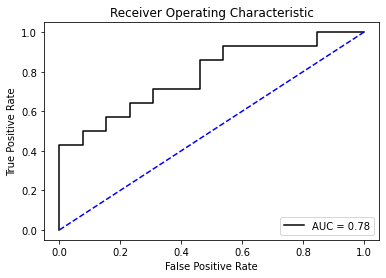

In [315]:
plot_roc_curve(tpr,fpr,AUC)

In [316]:
# GBC WPS without hyperparameter optimization default
gbc_wps_hpo = GradientBoostingClassifier(random_state = 42)
gbc_wps_hpo.fit(X_train_scaled_wps, y_train_scaled_wps)

#predict the test data
pred_train = gbc_wps_hpo.predict(X_train_scaled_wps)
prob_train = gbc_wps_hpo.predict_proba(X_train_scaled_wps)
pred = gbc_wps_hpo.predict(X_test_scaled_wps)
prob = gbc_wps_hpo.predict_proba(X_test_scaled_wps)
gbc_wps_hpo_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_wps, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_wps, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_wps, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_wps, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7407407407407407 AUC:  0.717032967032967


In [470]:
# GBC WPS without hyperparameter optimization manual

gbc_wps_manual = GradientBoostingClassifier(n_estimators=500, min_samples_split=6, min_samples_leaf=3, max_features='sqrt', 
    max_depth=3, criterion='friedman_mse', subsample=1, learning_rate=0.1, random_state = 42)
gbc_wps_manual.fit(X_train_scaled_wps, y_train_scaled_wps)

pred_train = gbc_wps_manual.predict(X_train_scaled_wps)
prob_train = gbc_wps_manual.predict_proba(X_train_scaled_wps)
pred = gbc_wps_manual.predict(X_test_scaled_wps)
prob = gbc_wps_manual.predict_proba(X_test_scaled_wps)
gbc_wps_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_wps, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_wps, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_wps, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_wps, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)


TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.8518518518518519 AUC:  0.956043956043956


## Results full coverage

In [317]:
# params
cancer_type = "breast_cancer"
GC = "corrected"
score = "COV"
amplitude = "FFT"

# cancer features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+cancer_type+"_"+GC+"_"+score+"_"+amplitude+"_features.csv"
c_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_breast_cancer_metadata.tsv"
c_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

c_features = c_features.reset_index(drop=False)
c_features[['sample','p','score']] = c_features['index'].str.split('_',2, expand=True)
c_features = c_features.set_index('sample')
cancer = pd.concat([c_features, c_meta], axis=1)

# healthy features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_"+GC+"_"+score+"_"+amplitude+"_features.csv"
h_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_metadata.tsv"
h_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

h_features = h_features.reset_index(drop=False)
h_features[['sample','p','score']] = h_features['index'].str.split('_',2, expand=True)
h_features = h_features.set_index('sample')
healthy = pd.concat([h_features, h_meta], axis=1)

# concat breast cancer and healthy
data_cov = pd.concat([cancer, healthy], axis=0)
features_cov = data_cov.columns[(data_cov.columns.str.startswith('central_cov')) | (data_cov.columns.str.startswith('mean_cov')) | (data_cov.columns.str.startswith('amplitude')) | (data_cov.columns.str.startswith('nucleosome_spacing'))]

train_cov,test_cov = train_test_split(data_cov, test_size = 0.25, random_state = 42)
X_train_cov = train_cov[features_cov]
y_train_cov = train_cov.loc[:,"phenotype"]
X_test_cov = test_cov[features_cov]
y_test_cov = test_cov.loc[:,"phenotype"]

scaled_data_cov = pd.concat([cancer, healthy], axis=0) 
scaler = StandardScaler()
scaler.fit(scaled_data_cov[features_cov])
scaled_data_cov[features_cov] = scaler.transform(scaled_data_cov[features_cov])
scaled_data_cov[features_cov].mean()

train_scaled_cov,test_scaled_cov = train_test_split(scaled_data_cov, test_size = 0.25, random_state = 42)
X_train_scaled_cov = train_scaled_cov[features_cov]
y_train_scaled_cov = train_scaled_cov.loc[:,"phenotype"]
X_test_scaled_cov = test_scaled_cov[features_cov]
y_test_scaled_cov = test_scaled_cov.loc[:,"phenotype"]

In [318]:
# RF COV
n_estimators = range(100,501,50)
max_features = ['sqrt','log2',None]
min_samples_leaf = range(2,6)
max_depth = range(3,16)
min_samples_split = range(2,5)
criterion = ['gini','entropy']

hyperparameters = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': [True,False],
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'criterion': criterion}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 
        
model = RandomForestClassifier()
search = RandomizedSearchCV(estimator = model, param_distributions = hyperparameters, n_iter = 1000,  cv = cv, verbose=3, n_jobs = -1, return_train_score=True)        
search.fit(X_train_scaled_wps, y_train_scaled_wps)

print("best score: ", search.best_score_)
print(search.best_params_)
best_n_estimators = search.best_params_['n_estimators']
best_max_features = search.best_params_['max_features']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_max_depth = search.best_params_['max_depth']
best_min_samples_split = search.best_params_['min_samples_split']
best_bootstrap = search.best_params_['bootstrap']
best_criterion = search.best_params_['criterion']

rf_cov_hpo = RandomForestClassifier(n_estimators=best_n_estimators, max_features=best_max_features, 
                               min_samples_leaf=best_min_samples_leaf, 
                               max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
                               bootstrap=best_bootstrap, criterion=best_criterion, random_state=42)
rf_cov_hpo.fit(X_train_scaled_cov, y_train_scaled_cov)

#predict the test data
pred_train = rf_cov_hpo.predict(X_train_scaled_cov)
prob_train = rf_cov_hpo.predict_proba(X_train_scaled_cov)
pred = rf_cov_hpo.predict(X_test_scaled_cov)
prob = rf_cov_hpo.predict_proba(X_test_scaled_cov)
rf_cov_hpo_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_cov, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_cov, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_cov, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_cov, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
best score:  0.8041666666666666
{'n_estimators': 150, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 8, 'criterion': 'gini', 'bootstrap': True}
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7777777777777778 AUC:  0.8186813186813188


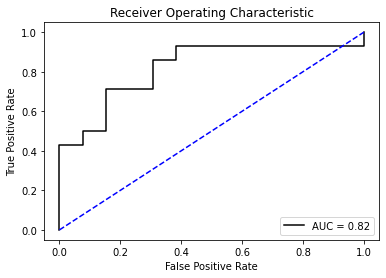

In [319]:
plot_roc_curve(tpr,fpr,AUC)

In [320]:
# RF COV without hyperparameter optimization default

rf_cov = RandomForestClassifier(random_state=42)
rf_cov.fit(X_train_scaled_cov, y_train_scaled_cov)

#predict the test data
pred_train = rf_cov.predict(X_train_scaled_cov)
prob_train = rf_cov.predict_proba(X_train_scaled_cov)
pred = rf_cov.predict(X_test_scaled_cov)
prob = rf_cov.predict_proba(X_test_scaled_cov)
rf_cov_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_cov, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_cov, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_cov, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_cov, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7037037037037037 AUC:  0.739010989010989


In [471]:
# RF COV without hyperparameter optimization default

rf_cov_manual = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', 
    max_depth=8, criterion='gini', bootstrap=True, random_state = 42)
rf_cov_manual.fit(X_train_scaled_cov, y_train_scaled_cov)

pred_train = rf_cov_manual.predict(X_train_scaled_cov)
prob_train = rf_cov_manual.predict_proba(X_train_scaled_cov)
pred = rf_cov_manual.predict(X_test_scaled_cov)
prob = rf_cov_manual.predict_proba(X_test_scaled_cov)
rf_cov_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled_cov, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled_cov, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled_cov, pred)
fpr,tpr,_ = roc_curve(y_test_scaled_cov, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7407407407407407 AUC:  0.7912087912087913


In [321]:
# GBC COV
n_estimators = range(100,501,50)
max_features = ['sqrt','log2',None]
min_samples_leaf = range(2,6)
max_depth = range(3,16)
min_samples_split = range(2,5)
learning_rate = np.arange(0.1,1.1,0.1)
subsample = np.arange(0.1,1.1,0.1)
criterion = ['friedman_mse','squared_error']
###### add other params?

hyperparameters = {'n_estimators': n_estimators,
                'max_features': max_features,
                'min_samples_leaf': min_samples_leaf,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'learning_rate': learning_rate,
                'subsample': subsample,
                'criterion': criterion}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42) 
        
model = GradientBoostingClassifier()
search = RandomizedSearchCV(estimator = model, param_distributions = hyperparameters, n_iter = 1000,  cv = cv, verbose=3, n_jobs = -1, return_train_score=True)        
search.fit(X_train_scaled_cov, y_train_scaled_cov)

print("best score: ", search.best_score_)
print(search.best_params_)
best_n_estimators = search.best_params_['n_estimators']
best_max_features = search.best_params_['max_features']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_max_depth = search.best_params_['max_depth']
best_min_samples_split = search.best_params_['min_samples_split']
best_learning_rate = search.best_params_['learning_rate']
best_subsample = search.best_params_['subsample']
best_criterion = search.best_params_['criterion']

gbc_cov_hpo = GradientBoostingClassifier(n_estimators=best_n_estimators, max_features=best_max_features, 
                               min_samples_leaf=best_min_samples_leaf, 
                               max_depth=best_max_depth, min_samples_split=best_min_samples_split, 
                               learning_rate=best_learning_rate, subsample=best_subsample, 
                               criterion=best_criterion, random_state=42)
gbc_cov_hpo.fit(X_train_scaled_cov, y_train_scaled_cov)

#predict the test data
pred_train = gbc_cov_hpo.predict(X_train_scaled_cov)
prob_train = gbc_cov_hpo.predict_proba(X_train_scaled_cov)
pred = gbc_cov_hpo.predict(X_test_scaled_cov)
prob = gbc_cov_hpo.predict_proba(X_test_scaled_cov)
gbc_cov_hpo_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
best score:  0.8527777777777779
{'subsample': 0.6, 'n_estimators': 250, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 6, 'learning_rate': 0.8, 'criterion': 'friedman_mse'}
TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7407407407407407 AUC:  0.8626373626373627


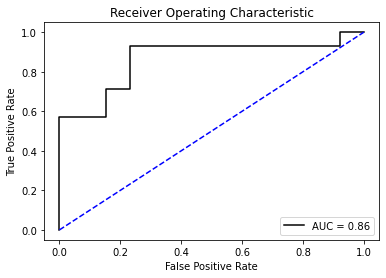

In [322]:
plot_roc_curve(tpr,fpr,AUC)

In [323]:
# GBC COV without hyperparameter optimization default

gbc_cov = GradientBoostingClassifier(random_state=42)
gbc_cov.fit(X_train_scaled_cov, y_train_scaled_cov)

#predict the test data
pred_train = gbc_cov.predict(X_train_scaled_cov)
prob_train = gbc_cov.predict_proba(X_train_scaled_cov)
pred = gbc_cov.predict(X_test_scaled_cov)
prob = gbc_cov.predict_proba(X_test_scaled_cov)
gbc_cov_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)

TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.7407407407407407 AUC:  0.8049450549450551


In [472]:
# GBC COV without hyperparameter optimization manual

gbc_cov_manual = GradientBoostingClassifier(n_estimators=500, min_samples_split=6, min_samples_leaf=3, max_features='sqrt', 
    max_depth=3, criterion='friedman_mse', subsample=1, learning_rate=0.1, random_state = 42)
gbc_cov_manual.fit(X_train_scaled, y_train_scaled)

pred_train = gbc_cov_manual.predict(X_train_scaled)
prob_train = gbc_cov_manual.predict_proba(X_train_scaled)
pred = gbc_cov_manual.predict(X_test_scaled)
prob = gbc_cov_manual.predict_proba(X_test_scaled)
gbc_cov_manual_prob = prob[:,1]

# train performance
acc = accuracy_score(y_train_scaled, pred_train)
fpr,tpr,_ = roc_curve(y_train_scaled, prob_train[:,1])
AUC = auc(fpr,tpr)
print('TRAINING - Accuracy: ', acc, 'AUC: ', AUC)

# test performance
acc = accuracy_score(y_test_scaled, pred)
fpr,tpr,_ = roc_curve(y_test_scaled, prob[:,1])
AUC = auc(fpr,tpr)
print('TESTING - Accuracy: ', acc, 'AUC: ', AUC)


TRAINING - Accuracy:  1.0 AUC:  1.0
TESTING - Accuracy:  0.8148148148148148 AUC:  0.8681318681318682


# Plots for the thesis
## log reg, RF, GBC (scaling with hyperparam. opt.)

In [562]:
extension = "pdf" #"pdf" "png"

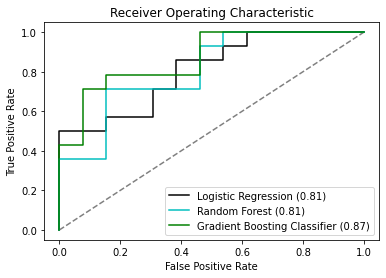

In [563]:
#fig = plt.gcf()
#fig.set_size_inches(9, 6)

fpr,tpr,threshold = roc_curve(y_test_scaled, log_reg_manual_scaled_prob)
AUC = auc(fpr,tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'k', label = 'Logistic Regression (%0.2f)' % AUC)
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
    
fpr,tpr,threshold = roc_curve(y_test_scaled, rf_manual_scaled_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'c', label = 'Random Forest (%0.2f)' % AUC)

fpr,tpr,threshold = roc_curve(y_test_scaled, gbc_manual_scaled_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'g', label = 'Gradient Boosting Classifier (%0.2f)' % AUC)

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/compare_binary_classification_new."+extension
plt.savefig(outfile)

## corrected/uncorrected

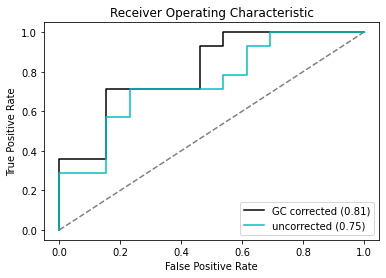

In [564]:
# Random Forest

#fig = plt.gcf()
#fig.set_size_inches(9, 6)

fpr,tpr,threshold = roc_curve(y_test_scaled, rf_manual_scaled_prob)
AUC = auc(fpr,tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'k', label = 'GC corrected (%0.2f)' % AUC)
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
    
fpr,tpr,threshold = roc_curve(y_test_scaled, rf_uncorrected_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'c', label = 'uncorrected (%0.2f)' % AUC)

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/RF_correction_new."+extension
plt.savefig(outfile)

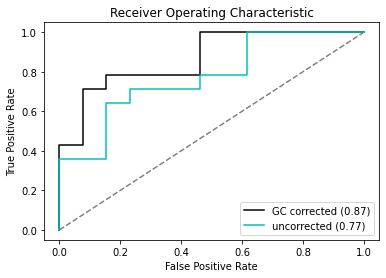

In [565]:
# Gradient Boosting Classifier

#fig = plt.gcf()
#fig.set_size_inches(9, 6)

fpr,tpr,threshold = roc_curve(y_test_scaled, gbc_manual_scaled_prob)
AUC = auc(fpr,tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'k', label = 'GC corrected (%0.2f)' % AUC)
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
    
fpr,tpr,threshold = roc_curve(y_test_scaled, gbc_uncorrected_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'c', label = 'uncorrected (%0.2f)' % AUC)

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/GBC_correction_new."+extension
plt.savefig(outfile)

## WPS, COV, MP

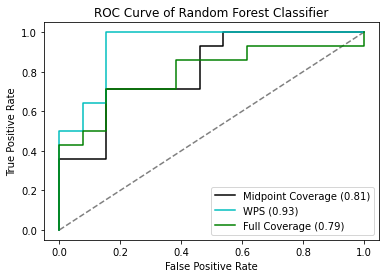

In [566]:
# Random Forest

#fig = plt.gcf()
#fig.set_size_inches(9, 6)

fpr,tpr,threshold = roc_curve(y_test_scaled, rf_manual_scaled_prob)
AUC = auc(fpr,tpr)

plt.title('ROC Curve of Random Forest Classifier')
plt.plot(fpr, tpr, 'k', label = 'Midpoint Coverage (%0.2f)' % AUC)
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
    
fpr,tpr,threshold = roc_curve(y_test_scaled, rf_wps_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'c', label = 'WPS (%0.2f)' % AUC)

fpr,tpr,threshold = roc_curve(y_test_scaled, rf_cov_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'g', label = 'Full Coverage (%0.2f)' % AUC)

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/RF_compare_scores_new."+extension
plt.savefig(outfile)

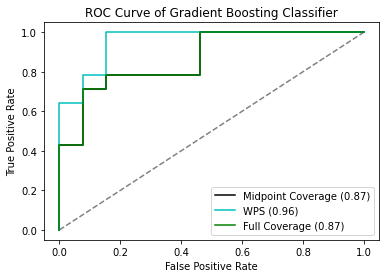

In [567]:
# Gradient Boosting

#fig = plt.gcf()
#fig.set_size_inches(9, 6)

fpr,tpr,threshold = roc_curve(y_test_scaled, gbc_manual_scaled_prob)
AUC = auc(fpr,tpr)

plt.title('ROC Curve of Gradient Boosting Classifier')
plt.plot(fpr, tpr, 'k', label = 'Midpoint Coverage (%0.2f)' % AUC)
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
    
fpr,tpr,threshold = roc_curve(y_test_scaled, gbc_wps_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'c', label = 'WPS (%0.2f)' % AUC)

fpr,tpr,threshold = roc_curve(y_test_scaled, gbc_cov_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'g', label = 'Full Coverage (%0.2f)' % AUC)

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/GBC_compare_scores_new."+extension
plt.savefig(outfile)

# Different feature combinations

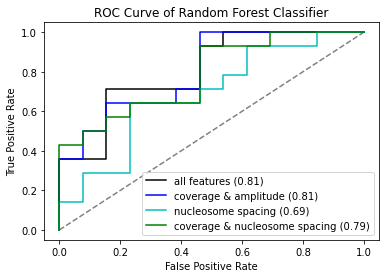

In [568]:
# Random Forest

#fig = plt.gcf()
#fig.set_size_inches(9, 6)

fpr,tpr,threshold = roc_curve(y_test_scaled, rf_manual_scaled_prob)
AUC = auc(fpr,tpr)

plt.title('ROC Curve of Random Forest Classifier')
plt.plot(fpr, tpr, 'k', label = 'all features (%0.2f)' % AUC)
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

fpr,tpr,threshold = roc_curve(y_test_scaled, rf_griffin_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'b', label = 'coverage & amplitude (%0.2f)' % AUC)
    
fpr,tpr,threshold = roc_curve(y_test_scaled, rf_mine_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'c', label = 'nucleosome spacing (%0.2f)' % AUC)

fpr,tpr,threshold = roc_curve(y_test_scaled, rf_mix_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'g', label = 'coverage & nucleosome spacing (%0.2f)' % AUC)

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/RF_compare_features_new."+extension
plt.savefig(outfile)

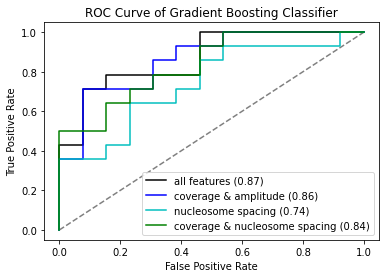

In [569]:
# Gradient Boosting Classifier

#fig = plt.gcf()
#fig.set_size_inches(9, 6)

fpr,tpr,threshold = roc_curve(y_test_scaled, gbc_manual_scaled_prob)
AUC = auc(fpr,tpr)

plt.title('ROC Curve of Gradient Boosting Classifier')
plt.plot(fpr, tpr, 'k', label = 'all features (%0.2f)' % AUC)
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

fpr,tpr,threshold = roc_curve(y_test_scaled, gbc_griffin_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'b', label = 'coverage & amplitude (%0.2f)' % AUC)
    
fpr,tpr,threshold = roc_curve(y_test_scaled, gbc_mine_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'c', label = 'nucleosome spacing (%0.2f)' % AUC)

fpr,tpr,threshold = roc_curve(y_test_scaled, gbc_mix_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'g', label = 'coverage & nucleosome spacing (%0.2f)' % AUC)

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/GBC_compare_features_new."+extension
plt.savefig(outfile)

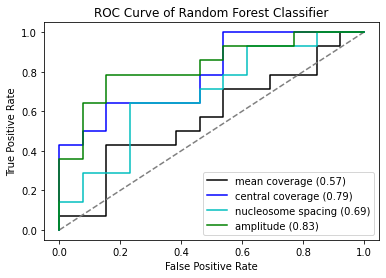

In [570]:
# Random Forest

#fig = plt.gcf()
#fig.set_size_inches(9, 6)

fpr,tpr,threshold = roc_curve(y_test_scaled, rf_mean_manual_prob)
AUC = auc(fpr,tpr)

plt.title('ROC Curve of Random Forest Classifier')
plt.plot(fpr, tpr, 'k', label = 'mean coverage (%0.2f)' % AUC)
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

fpr,tpr,threshold = roc_curve(y_test_scaled, rf_central_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'b', label = 'central coverage (%0.2f)' % AUC)
    
fpr,tpr,threshold = roc_curve(y_test_scaled, rf_mine_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'c', label = 'nucleosome spacing (%0.2f)' % AUC)

fpr,tpr,threshold = roc_curve(y_test_scaled, rf_amplitude_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'g', label = 'amplitude (%0.2f)' % AUC)

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/RF_compare_single_features."+extension
plt.savefig(outfile)

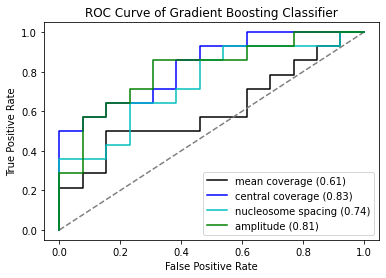

In [571]:
# Gradient Boosting Classifier

#fig = plt.gcf()
#fig.set_size_inches(9, 6)

fpr,tpr,threshold = roc_curve(y_test_scaled, gbc_mean_manual_prob)
AUC = auc(fpr,tpr)

plt.title('ROC Curve of Gradient Boosting Classifier')
plt.plot(fpr, tpr, 'k', label = 'mean coverage (%0.2f)' % AUC)
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

fpr,tpr,threshold = roc_curve(y_test_scaled, gbc_central_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'b', label = 'central coverage (%0.2f)' % AUC)
    
fpr,tpr,threshold = roc_curve(y_test_scaled, gbc_mine_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'c', label = 'nucleosome spacing (%0.2f)' % AUC)

fpr,tpr,threshold = roc_curve(y_test_scaled, gbc_amplitude_manual_prob)
AUC = auc(fpr,tpr)
plt.plot(fpr, tpr, 'g', label = 'amplitude (%0.2f)' % AUC)

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/GBC_compare_single_features."+extension
plt.savefig(outfile)

## Feature importance plots

Text(0.5, 0, 'Importance')

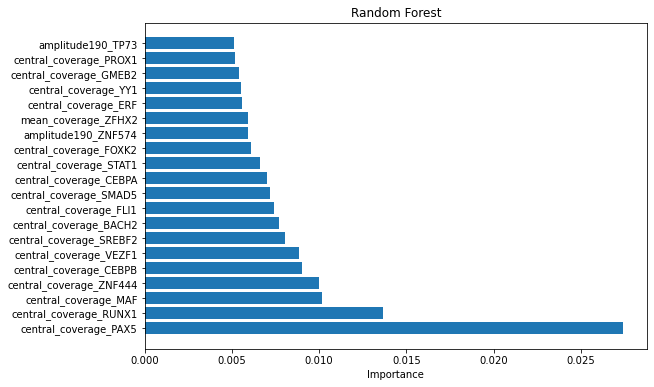

In [540]:
fig = plt.gcf()
fig.set_size_inches(9, 6)

n_features = 20

plt.title('Random Forest')

feature_importance = pd.Series(rf_manual_scaled.feature_importances_, index=features).nlargest(n_features)
plt.barh(feature_importance.index,feature_importance)

plt.ylabel('')
plt.xlabel('Importance')

Text(0.5, 0, 'Importance')

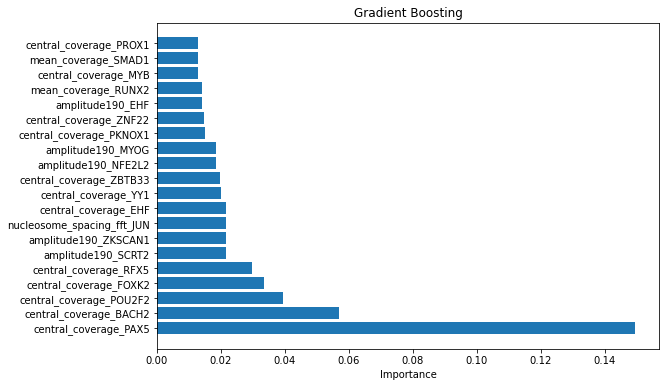

In [544]:
fig = plt.gcf()
fig.set_size_inches(9, 6)

n_features = 20

plt.title('Gradient Boosting')

feature_importance = pd.Series(gbc_manual_scaled.feature_importances_, index=features).nlargest(n_features)
plt.barh(feature_importance.index,feature_importance)

plt.ylabel('')
plt.xlabel('Importance')

Text(0.5, 0, 'Importance')

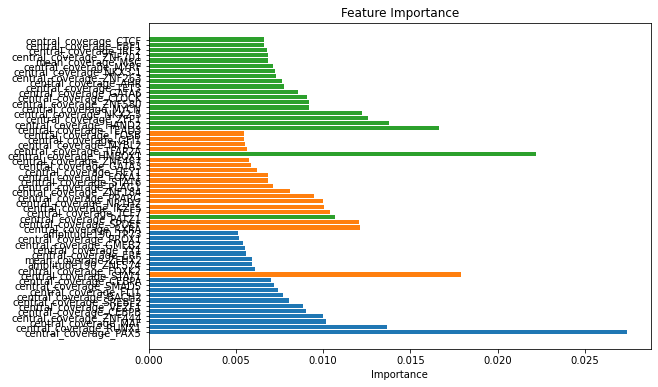

In [541]:
fig = plt.gcf()
fig.set_size_inches(9, 6)

n_features = 20

plt.title('Feature Importance')

feature_importance = pd.Series(rf_manual_scaled.feature_importances_, index=features).nlargest(n_features)
plt.barh(feature_importance.index,feature_importance, label="Midpoint Coverage")

feature_importance = pd.Series(rf_wps_manual.feature_importances_, index=features).nlargest(n_features)
plt.barh(feature_importance.index,feature_importance, label="WPS")

feature_importance = pd.Series(rf_cov_manual.feature_importances_, index=features).nlargest(n_features)
plt.barh(feature_importance.index,feature_importance, label="Full Coverage")

plt.ylabel('')
plt.xlabel('Importance')